In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.interpolate as interp
import matplotlib as mpl

import seaborn as sns
sns.set_style("dark")


mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
mpl.rcParams.update({'font.size': 18})
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
#paths

#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
path_data = '/users/caganze/research/stellarstreams/data/rotating/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


from matplotlib.gridspec import GridSpec
%matplotlib inline
#%matplotlib notebook

## Test IMF pdf sampling for the full IMF (m = 0.01 - 120 Msun), with ~ m^(-0.5)

In [3]:
def sample_from_powerlaw(alpha, xmin=0.1, xmax=1, nsample=int(1e4)):
    x= np.linspace(xmin, xmax, int(1e6))
    pdf=x**alpha
    cdf=np.cumsum(pdf)
    return random_draw(x, cdf, nsample=int(nsample))

def random_draw(x_grid, cdf, nsample=10):
   # cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(nsample)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf


path_data = '/users/caganze/research/stellarstreams/data/stream/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'

In [4]:
sample_allmasses=sample_from_powerlaw(-0.5, xmin=0.01, xmax=120, nsample=10_000)

Text(0.5, 1.0, 'IMF ~ m^(-1/2)')

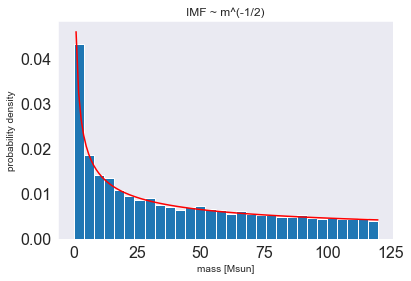

In [5]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
n, bins, h = ax.hist(sample_allmasses, range = [0.01, 120], bins = 30, density = True)
x = np.linspace(1,120,120)
y = 1.0/(2*np.sqrt(120)-2*np.sqrt(0.01))*x**(-1./2)
ax.plot(x,y, 'r-')
ax.set_ylabel('probability density')
ax.set_xlabel('mass [Msun]')
ax.set_title('IMF ~ m^(-1/2)')

Now run IMF sampling for masses that are relevant for a Pal-5 like simple stellar population (age and metallicity), interpolate to CFHT MegaCam g-mag and stop when Ibata number of stars (1761?) between 20 < g < 23.


In [6]:
D_MOD_PAL5= 16.8553 
D_MOD_GALAX = 7.66# fact of 34.14 farther away than Pal 5 M31 24.47 #from Ibata+2014
MAG_LIMIT=28.54

In [7]:
16.8553 + 7.66

24.5153

number of stars samples: 3000
IMF sampling luminosity function number of stars in 20 < g < 23: 473


Text(0.5, 1.0, 'IMF ~ m^(-1/2)')

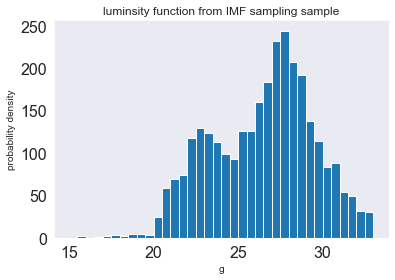

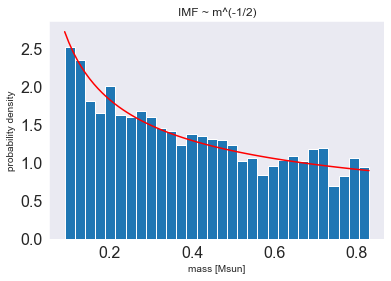

In [8]:
cfht_mini = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
cfht_gmag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [24])
cfht_imag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [25])
wfirst_mini = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
wfirst_mags = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [23,24,25,26,27,28,29])

# #Trying younger  cluster
# cfht_mini = np.loadtxt('Isochrone_CFHT_Parsec_500Myr_z0.txt', skiprows = 8, usecols = [2])
# cfht_gmag = np.loadtxt('Isochrone_CFHT_Parsec_500Myr_z0.txt', skiprows = 8, usecols = [24])
# cfht_imag = np.loadtxt('Isochrone_CFHT_Parsec_500Myr_z0.txt', skiprows = 8, usecols = [25])
# wfirst_mini = np.loadtxt('Isochrone_WFIRST_Parsec_WitnDust_500Myr_z0.txt', skiprows = 8, usecols = [2])
# wfirst_mags = np.loadtxt('Isochrone_WFIRST_Parsec_WitnDust_500Myr_z0.txt', skiprows = 8, usecols = [23,24,25,26,27,28,29])


inter_gmags = interp.interp1d(cfht_mini, cfht_gmag)
inter_imags = interp.interp1d(cfht_mini, cfht_imag)
inter_Rmags = interp.interp1d(wfirst_mini, wfirst_mags[:,0])
inter_Zmags = interp.interp1d(wfirst_mini, wfirst_mags[:,1])
inter_Ymags = interp.interp1d(wfirst_mini, wfirst_mags[:,2])
inter_Jmags = interp.interp1d(wfirst_mini, wfirst_mags[:,3])
inter_Hmags = interp.interp1d(wfirst_mini, wfirst_mags[:,4])
inter_Fmags = interp.interp1d(wfirst_mini, wfirst_mags[:,5])
inter_Wmags = interp.interp1d(wfirst_mini, wfirst_mags[:,6])

## double check whether the minimum and maximum M_ini values are the same: True
#print np.max(cfht_mini), np.max(wfirst_mini), np.min(cfht_mini), np.min(wfirst_mini)


#my_imf_low = imf_sub(a=np.min(cfht_mini), b=np.max(cfht_mini), name='sub')
sample_lowmasses = []
tot_norm = 0


#while tot_norm < 3000:#1767: #
#    sample_lowmasses.append(my_imf_low.rvs(size=1))

sample_lowmasses=sample_from_powerlaw(-0.5, xmin=np.min(cfht_mini), xmax=np.max(cfht_mini), nsample=int(3000))
sample_gmags = inter_gmags(sample_lowmasses) + D_MOD_PAL5
hist_gmag, bins_edges = np.histogram(sample_gmags, bins = 36, range = [15, 33])
bins_gmag = (bins_edges[:-1] + bins_edges[1:])*0.5
tot_norm = np.sum(hist_gmag[np.logical_and(bins_gmag < 23, bins_gmag > 20)])
    
print('number of stars samples: '+ str(len(sample_lowmasses)))
print('IMF sampling luminosity function number of stars in 20 < g < 23: '+ str(tot_norm))

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_ylabel('probability density')
ax.set_xlabel('g')
ax.set_title('luminsity function from IMF sampling sample')
h, be, p = ax.hist(sample_gmags, bins = 36, range = [15, 33])    

sample_lowmasses = np.asarray(sample_lowmasses)   
    
fig, ax = plt.subplots(1,1, figsize=[6,4])
n, bins, p = ax.hist(sample_lowmasses, range = [0.09, 0.83], bins = 30, density = True)
x = np.linspace(0.09,0.83,74)
y = 1.0/(2*np.sqrt(0.83)-2*np.sqrt(0.09))*x**(-1./2)
ax.plot(x,y, 'r-')
ax.set_ylabel('probability density')
ax.set_xlabel('mass [Msun]')
ax.set_title('IMF ~ m^(-1/2)')

Do initial mass - magnitude interpolation to get CFHT MegaCam g-mag, i-mag, and WFIRST mags luminosity function, for Pal-5 like age and metallicity simple stellar population

## check maximume distance limit for cluster

In [9]:
# plt.figure()
# plt.plot(wfirst_Z[:-1]-wfirst_J[:-1] , wfirst_Z[:-1]+d_mod_test)
# #plt.plot(wfirst_Z[:-1]-wfirst_J[:-1] , wfirst_Z[:-1]+d_mod_test_fac10)
# plt.ylim([35,15])
#    # ax[0].set_title('Isochrone from PARSEC')
# plt.fill_between([-1,4],28.4,28.64,color='black', alpha=0.3)
# plt.fill_between([-1,4],27.0,27.25,color='red', alpha=0.3)
# #plt.text(-0.8,27.9-d_mod_test, 'd = 785 kpc (M31), WFIRST', fontsize=16)
# #plt.fill_between([-1,4],28.4,28.64,color='black', alpha=0.3)
# #plt.text(-0.8,27.9, 'd = 23.5 kpc (Pal 5), WFIRST', fontsize=16)
# plt.xlim([-1,3])
# plt.ylabel('WFIRST Z087')
# plt.xlabel('WFIRST $Z087 - J129$')

## Do 5 times more massive stream

number of stars samples: 15000
IMF sampling luminosity function number of stars in 20 < g < 23: 2289


Text(0.5, 1.0, 'IMF ~ m^(-1/2)')

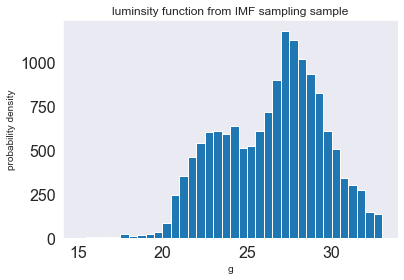

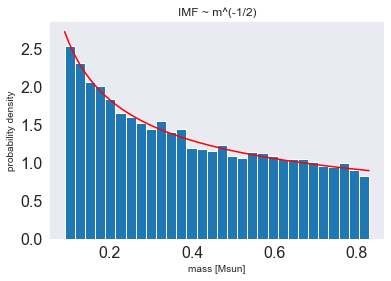

In [10]:
######### Doing sampler again but 10x for more stars 


# #sample from IMF sub-region renormalize to the right edges.
# class imf_sub(st.rv_continuous):
#     def _pdf(self,x):
#         return 1.0/(2*np.sqrt(np.max(cfht_mini))-2*np.sqrt(np.min(cfht_mini)))*x**(-0.5)  # Normalized over its range, in this case [0.01,120]


# my_imf_low = imf_sub(a=np.min(cfht_mini), b=np.max(cfht_mini), name='sub')
sample_lowmasses_m5 = []
tot_norm_m5 = 0


d_mod = 16.8553 ##distance modulus Pal5

#while tot_norm_m5 < 15000:#17670: #
#sample_lowmasses_m5.append(my_imf_low.rvs(size=1))
sample_lowmasses_m5=sample_from_powerlaw(-0.5, xmin=np.min(cfht_mini), xmax=np.max(cfht_mini), nsample=int(15000))
sample_gmags_m5 = inter_gmags(sample_lowmasses_m5) + d_mod
hist_gmag, bins_edges = np.histogram(sample_gmags_m5, bins = 36, range = [15, 33])
bins_gmag = (bins_edges[:-1] + bins_edges[1:])*0.5
tot_norm_m5 = np.sum(hist_gmag[np.logical_and(bins_gmag < 23, bins_gmag > 20)])

print('number of stars samples: '+ str(len(sample_lowmasses_m5)))
print('IMF sampling luminosity function number of stars in 20 < g < 23: '+ str(tot_norm_m5))

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_ylabel('probability density')
ax.set_xlabel('g')
ax.set_title('luminsity function from IMF sampling sample')
h, be, p = ax.hist(sample_gmags_m5, bins = 36, range = [15, 33])    

sample_lowmasses_m5 = np.asarray(sample_lowmasses_m5)   
    
fig, ax = plt.subplots(1,1, figsize=[6,4])
n, bins, p = ax.hist(sample_lowmasses_m5, range = [0.09, 0.83], bins = 30, density = True)
x = np.linspace(0.09,0.83,74)
y = 1.0/(2*np.sqrt(0.83)-2*np.sqrt(0.09))*x**(-1./2)
ax.plot(x,y, 'r-')
ax.set_ylabel('probability density')
ax.set_xlabel('mass [Msun]')
ax.set_title('IMF ~ m^(-1/2)')

In [11]:
### W

number of stars samples: 30000
IMF sampling luminosity function number of stars in 20 < g < 23: 4618


Text(0.5, 1.0, 'IMF ~ m^(-1/2)')

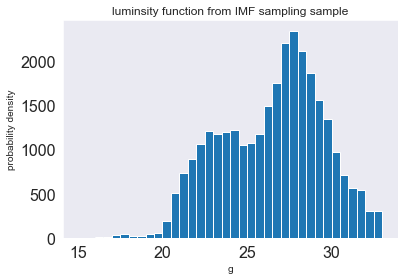

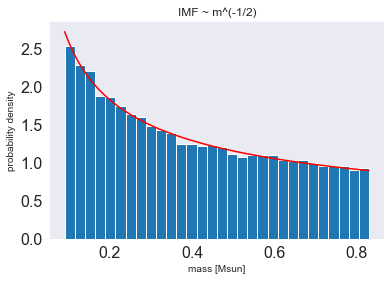

In [12]:
######### Doing sampler again but 10x for more stars 


# #sample from IMF sub-region renormalize to the right edges.
# class imf_sub(st.rv_continuous):
#     def _pdf(self,x):
#         return 1.0/(2*np.sqrt(np.max(cfht_mini))-2*np.sqrt(np.min(cfht_mini)))*x**(-0.5)  # Normalized over its range, in this case [0.01,120]


# my_imf_low = imf_sub(a=np.min(cfht_mini), b=np.max(cfht_mini), name='sub')
sample_lowmasses_m10 = []
tot_norm_m10 = 0


d_mod = 16.8553 ##distance modulus Pal5

#while tot_norm_m10 < 30000:#17670: #
sample_lowmasses_m10=sample_from_powerlaw(-0.5, xmin=np.min(cfht_mini), xmax=np.max(cfht_mini), nsample=int(30000))
sample_gmags_m10 = inter_gmags(sample_lowmasses_m10) + d_mod
hist_gmag, bins_edges = np.histogram(sample_gmags_m10, bins = 36, range = [15, 33])
bins_gmag = (bins_edges[:-1] + bins_edges[1:])*0.5
tot_norm_m10 = np.sum(hist_gmag[np.logical_and(bins_gmag < 23, bins_gmag > 20)])
    
print('number of stars samples: '+ str(len(sample_lowmasses_m10)))
print('IMF sampling luminosity function number of stars in 20 < g < 23: '+ str(tot_norm_m10))

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_ylabel('probability density')
ax.set_xlabel('g')
ax.set_title('luminsity function from IMF sampling sample')
h, be, p = ax.hist(sample_gmags_m10, bins = 36, range = [15, 33])    

sample_lowmasses_m10 = np.asarray(sample_lowmasses_m10)   
    
fig, ax = plt.subplots(1,1, figsize=[6,4])
n, bins, p = ax.hist(sample_lowmasses_m10, range = [0.09, 0.83], bins = 30, density = True)
x = np.linspace(0.09,0.83,74)
y = 1.0/(2*np.sqrt(0.83)-2*np.sqrt(0.09))*x**(-1./2)
ax.plot(x,y, 'r-')
ax.set_ylabel('probability density')
ax.set_xlabel('mass [Msun]')
ax.set_title('IMF ~ m^(-1/2)')

In [13]:
wfirst_R = wfirst_mags[:,0]
wfirst_Z = wfirst_mags[:,1]
wfirst_J = wfirst_mags[:,4]

In [14]:
mag_array = np.linspace(10,35,1000)
cum_stars_g = np.zeros(len(mag_array))
for i in range(len(mag_array)):
    no = len(np.where(sample_gmags < mag_array[i])[0])
   # print(no)
    cum_stars_g[i] = no

cum_stars_g_m5 = np.zeros(len(mag_array))
for i in range(len(mag_array)):
    no_m5 = len(np.where(sample_gmags_m5 < mag_array[i])[0])
   # print(no)
    cum_stars_g_m5[i] = no_m5
    
    
cum_stars_g_m10 = np.zeros(len(mag_array))
for i in range(len(mag_array)):
    no_m10 = len(np.where(sample_gmags_m10 < mag_array[i])[0])
   # print(no)
    cum_stars_g_m10[i] = no_m10


####Figure out how many stars to populate stream with:
#len(np.where((sample_gmags > 20) & (sample_gmags < 23) )[0]) should be 1767
nstars_pandas = len(np.where((sample_gmags < 25.5 - D_MOD_GALAX))[0])
nstars_pandas_m5 = len(np.where((sample_gmags_m5 < 25.5 - D_MOD_GALAX))[0])
nstars_pandas_m10 = len(np.where((sample_gmags_m10 < 25.5 - D_MOD_GALAX))[0])

In [15]:
nstars_pandas, nstars_pandas_m5, nstars_pandas_m10, d_mod

(8, 41, 94, 16.8553)

<function print>

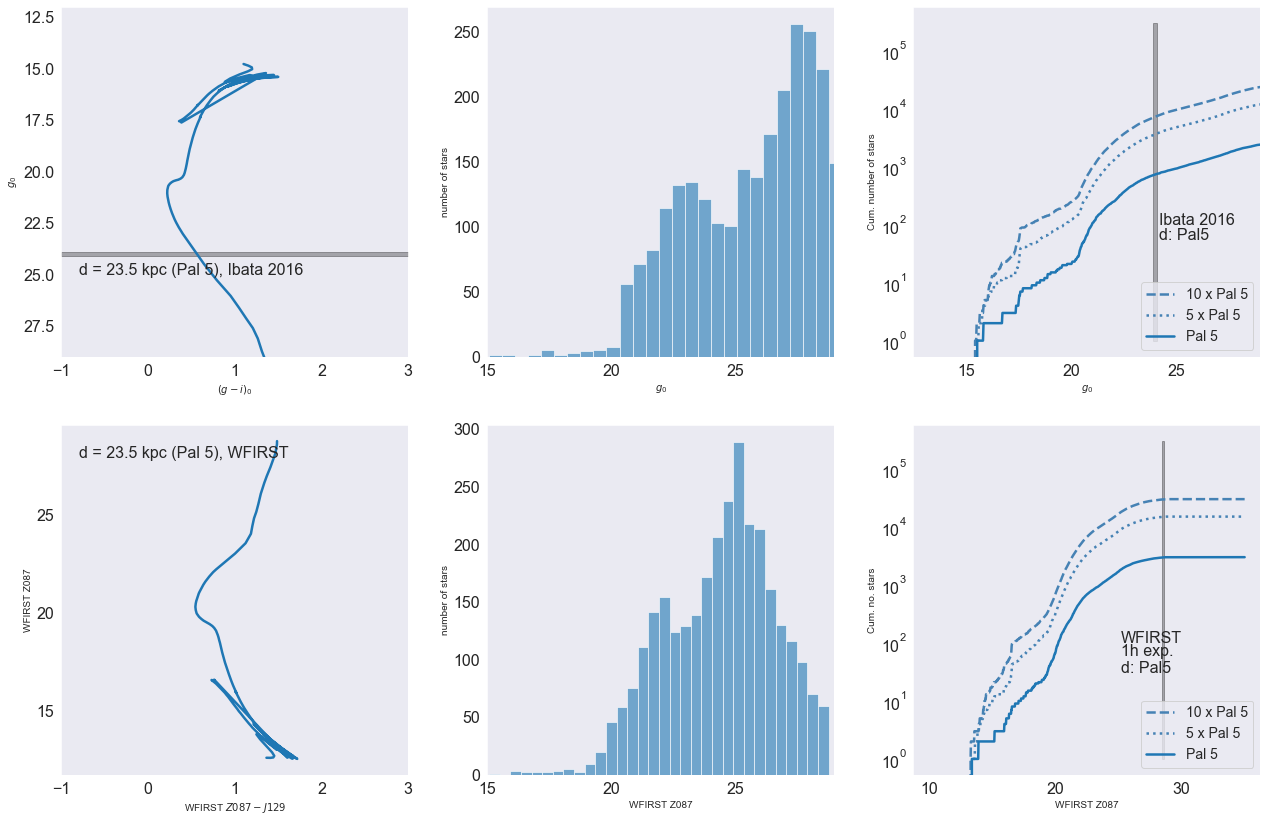

In [16]:

fig, ax = plt.subplots(2,3, figsize=[18,12])
mpl.rcParams.update({'font.size': 26})
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

ax[0,0].plot(cfht_gmag[:-1] - cfht_imag[:-1], cfht_gmag[:-1] + d_mod, linewidth=2.5)
ax[0,0].set_ylim([29,12])
#ax[0].set_title('Isochrone from PARSEC')
ax[0,0].set_xlim([-1,3])
#ax[0,0].fill_between([-1,4],25.4D_MOD_GALAX,25.6-D_MOD_GALAX,color='black', alpha=0.3)
#ax[0,0].text(-0.8,26.6-D_MOD_GALAX, 'd = 785 kpc (M 31), Pandas', fontsize=16)

ax[0,0].fill_between([-1,4],23.9,24.1,color='black', alpha=0.3)
ax[0,0].text(-0.8,25, 'd = 23.5 kpc (Pal 5), Ibata 2016', fontsize=16)
#ax[0,0].fill_between([-1,4],22.2,22.4,color='black', alpha=0.3)
#ax[0,0].text(-0.5,22.0, 'd = 23.5 kpc (Pal 5), SDSS', fontsize=16)
ax[0,0].set_ylabel('$g_0$')
ax[0,0].set_xlabel('$(g-i)_0$')

ax[0,1].set_ylabel('number of stars')
ax[0,1].set_xlabel('$g_0$')
#ax[1].set_title('luminsity function from IMF sampling')
ax[0,1].set_xlim([15,29])
#ax[0,1].set_ylim([0,1700])
h, be, p = ax[0,1].hist(sample_gmags, bins = 36, range = [14, 33], alpha=0.6) 


ax[0,2].plot(mag_array, cum_stars_g_m10, color='steelblue',linestyle='--', label='10 x Pal 5', linewidth=2.5)
ax[0,2].plot(mag_array, cum_stars_g_m5, color='steelblue',linestyle=':', label='5 x Pal 5', linewidth=2.5)
ax[0,2].plot(mag_array, cum_stars_g, label='Pal 5', linewidth=2.5)
#ax[2].plot(mag_array + dist_mod_And, cum_stars_g)
ax[0,2].set_yscale('log')
ax[0,2].set_xlabel('$g_0$')
#ax[2].set_title("At Pal5's distance")
ax[0,2].set_ylabel('Cum. number of stars')
ax[0,2].fill_between([23.9,24.1],1,300000,color='black', alpha=0.3)
ax[0,2].text(24.2,10**2, 'Ibata 2016', fontsize=16)
ax[0,2].text(24.2,5.5*10, 'd: Pal5', fontsize=16)
###axes[2].axhline(24, color = 'mediumpurple', linestyle='-.', label="CFHT, Ibata 2016")
#ax[0,2].fill_between([22.2,22.4],1,300000,color='black', alpha=0.3)
#ax[0,2].text(22.5,7*10**4, 'SDSS', fontsize=16)
#ax[0,2].text(22.5,4*10**4, 'd: Pal5', fontsize=16)
#ax[0,2].fill_between([25.4-dist_mod_And,25.6-dist_mod_And],1,300000,color='black', alpha=0.3)
#ax[0,2].text(25.6-dist_mod_And,7*10**4, 'PAndAS', fontsize=16)
#ax[0,2].text(25.6-dist_mod_And,4*10**4, 'd: M31', fontsize=16)
#ax[0,2].text(22.4-dist_mod_And,7*10**4, 'SDSS', fontsize=16)
#ax[0,2].text(22.4-dist_mod_And,4*10**4, 'd: M31', fontsize=16)
#ax[0,2].fill_between([22.2-dist_mod_And,22.4-dist_mod_And],1,300000,color='black', alpha=0.3)

#ax[0,2].text(25.7-dist_mod_And,nstars_pandas-4, 'n*=' + str(nstars_pandas), fontsize=16)
#ax[0,2].text(25.7-dist_mod_And,nstars_pandas_m5, 'n*=' + str(nstars_pandas_m5), fontsize=16)
#ax[0,2].text(25.7-dist_mod_And,nstars_pandas_m10+150, 'n*=' + str(nstars_pandas_m10), fontsize=16)

#ax[0,2].set_ylim([0,300000])
ax[0,2].set_xlim([12.5,29])
ax[0,2].legend(fontsize=14, loc='lower right')

# ax[1,1].plot(mag_array + 7.6, cum_stars_g)
# ax[1,1].set_yscale('log')
# ax[1,1].set_xlabel('$g$ mag')
# ax[1,1].set_title("At M31's distance")
# ax[1,1].set_ylabel('Cum. number of stars')
# ax[1,1].fill_between([25.4,25.6],1,30000,color='steelblue', alpha=0.3)
# ax[1,1].text(25.6,10**3, 'PANDAS', fontsize=14)
# ax[1,1].fill_between([22.2,22.4],1,30000,color='steelblue', alpha=0.3)
# ax[1,1].text(22.4,10**3, 'SDSS', fontsize=14)
# ax[1,1].set_ylim([0,30000])


if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
    print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
else:    
    #CFHT magnitudes
    sample_gmags = inter_gmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_imags = inter_imags(sample_lowmasses) + d_mod #distance modulus Pal5
    #WFIRST magnitudes
    sample_Rmags = inter_Rmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Zmags = inter_Zmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Ymags = inter_Ymags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Jmags = inter_Jmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Hmags = inter_Hmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Fmags = inter_Fmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Wmags = inter_Wmags(sample_lowmasses) + d_mod #distance modulus Pal5



        #resample to have 10xmire stars 

if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
    print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
else:    
    #CFHT magnitudes
    sample_gmags_m5 = inter_gmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_imags_m5 = inter_imags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    #WFIRST magnitudes
    sample_Rmags_m5 = inter_Rmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Zmags_m5 = inter_Zmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Ymags_m5 = inter_Ymags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Jmags_m5 = inter_Jmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Hmags_m5 = inter_Hmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Fmags_m5 = inter_Fmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Wmags_m5 = inter_Wmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5



        #resample to have 10xmire stars         

if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
    print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
else:    
    #CFHT magnitudes
    sample_gmags_m10 = inter_gmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_imags_m10 = inter_imags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    #WFIRST magnitudes
    sample_Rmags_m10 = inter_Rmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Zmags_m10 = inter_Zmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Ymags_m10 = inter_Ymags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Jmags_m10 = inter_Jmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Hmags_m10 = inter_Hmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Fmags_m10 = inter_Fmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Wmags_m10 = inter_Wmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5

   # sample_Zmags_m10 = inter_Zmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5

    ### SUM up histogram ###

    mag_array = np.linspace(10,35,1000)
    cum_stars_R = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Rmags < mag_array[i])[0])
        #print(no)
        cum_stars_R[i] = no

    mag_array = np.linspace(10,35,1000)
    cum_stars_Z = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Zmags < mag_array[i])[0])
        #print(no)
        cum_stars_Z[i] = no

    mag_array = np.linspace(10,35,1000)
    cum_stars_Z_m5 = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Zmags_m5 < mag_array[i])[0])
        #print(no)
        cum_stars_Z_m5[i] = no      

    mag_array = np.linspace(10,35,1000)
    cum_stars_Z_m10 = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Zmags_m10 < mag_array[i])[0])
        #print(no)
        cum_stars_Z_m10[i] = no    

    nstars_wfirst = len(np.where((sample_Zmags < MAG_LIMIT-D_MOD_GALAX))[0])
    nstars_wfirst_m5 = len(np.where((sample_Zmags_m5 < MAG_LIMIT-D_MOD_GALAX))[0])
    nstars_wfirst_m10 = len(np.where((sample_Zmags_m10 < MAG_LIMIT-D_MOD_GALAX))[0])

    ax[1,0].plot(wfirst_Z[:-1]-wfirst_J[:-1] , wfirst_Z[:-1]+ d_mod, linewidth=2.5)#wfirst_R[:-1] + d_mod, linewidth=2.5)
    #ax[1,0].set_ylim([29,12])
   # ax[0].set_title('Isochrone from PARSEC')
    #ax[1,0].fill_between([-1,4],28.4-dist_mod_And,28.64-dist_mod_And,color='black', alpha=0.3)
    #ax[1,0].text(-0.8,27.9-dist_mod_And, 'd = 785 kpc (M31), WFIRST', fontsize=16)
    #ax[1,0].fill_between([-1,4],28.4,28.64,color='black', alpha=0.3)
    ax[1,0].text(-0.8,27.9, 'd = 23.5 kpc (Pal 5), WFIRST', fontsize=16)
    ax[1,0].set_xlim([-1,3])
    ax[1,0].set_ylabel('WFIRST Z087')
    ax[1,0].set_xlabel('WFIRST $Z087 - J129$')
   # ax[1,0].fill_between([-1,4],27.0-13.5,27.25-13.5,color='black', alpha=0.1)


    ax[1,1].set_ylabel('number of stars')
    ax[1,1].set_xlabel('WFIRST Z087')
  #  ax[1].set_title('luminsity function from IMF sampling')
    ax[1,1].set_xlim([15,29])
    #ax[1,1].set_ylim([0,1700])
    h, be, p = ax[1,1].hist(sample_Zmags, bins = 36, alpha=0.6)

    ax[1,2].plot(mag_array, cum_stars_Z_m10, color='steelblue',linestyle='--',label='10 x Pal 5', linewidth=2.5)
    ax[1,2].plot(mag_array, cum_stars_Z_m5, color='steelblue',linestyle=':',label='5 x Pal 5', linewidth=2.5)
    ax[1,2].plot(mag_array, cum_stars_Z,label= 'Pal 5', linewidth=2.5)
    #ax[2].set_title("At Pal5's distance")
    ax[1,2].set_yscale('log')
    ax[1,2].set_xlabel('WFIRST Z087')
    ax[1,2].fill_between([28.44,28.64],1,300000,color='black', alpha=0.3)
    ax[1,2].text(25.2,10**2, 'WFIRST', fontsize=16)
    ax[1,2].text(25.2,6*10**1, '1h exp.', fontsize=16)
    ax[1,2].text(25.2,3*10**1, 'd: Pal5', fontsize=16)
    #ax[1,2].fill_between([28.55-dist_mod_And,28.75-dist_mod_And],1,300000,color='black', alpha=0.3)
    #ax[1,2].text(25.3-dist_mod_And,10**1, 'WFIRST', fontsize=16)
    #ax[1,2].text(25.3-dist_mod_And,6*10**0, '1h exp.', fontsize=16)
    #ax[1,2].text(25.3-dist_mod_And,3*10**0, 'd: M31', fontsize=16)
    ax[1,2].set_ylabel('Cum. no. stars')

    #ax[1,2].text(28.84-dist_mod_And,nstars_wfirst-4, 'n*=' + str(nstars_wfirst), fontsize=16)
    #ax[1,2].text(28.84-dist_mod_And,nstars_wfirst_m5, 'n*=' + str(nstars_wfirst_m5), fontsize=16)
    #ax[1,2].text(28.84-dist_mod_And,nstars_wfirst_m10+2000, 'n*=' + str(nstars_wfirst_m10), fontsize=16)

    #ax[1,2].set_ylim([0,300000])
    #ax[1,2].set_xlim([12.5,29])
    ax[1,2].legend(fontsize=14, loc='lower right')


#     ax[1,1].plot(mag_array+7.6, cum_stars_Z)
#     ax[1,1].plot(mag_array+7.6, cum_stars_Z*10, color='steelblue',linestyle='--')
#     ax[1,1].set_yscale('log')
#     ax[1,1].set_xlabel('WFIRST Z062')
#     ax[1,1].set_title("At M31's distance")
#     ax[1,1].set_ylabel('Cum. no. stars')
#     ax[1,1].fill_between([27.05,27.25],1,300000,color='steelblue', alpha=0.3)
#     ax[1,1].text(25.6,10**3, 'WFIRST, guest obs.', fontsize=14)
#     ax[1,1].set_ylim([0,300000])
    fig.tight_layout()
    fig.savefig('../figures/FIG1_CFHT_WFIRST_IMF3000_Z2854.pdf',)
    #fig.savefig('FIG1_CFHT_WFIRST_IMF3000_500Myr_z0.pdf',  rasterized=True)
#G-band limiting mag: 25.5 with S/N=10 
#https://urldefense.proofpoint.com/v2/url?u=https-3A__www.noao.edu_meetings_m31_files_Martin-5FPAndAS.pdf-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=fMUmbThfQiJFFZ2JYFKq22-Ldy5mlRVPJfBynveBrUg&e= #PUT SDSS and PANDAS limits on (same g-band) 





    
print 


#G-band limiting mag: 25.5 with S/N=10 
#https://urldefense.proofpoint.com/v2/url?u=https-3A__www.noao.edu_meetings_m31_files_Martin-5FPAndAS.pdf-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=fMUmbThfQiJFFZ2JYFKq22-Ldy5mlRVPJfBynveBrUg&e= #PUT SDSS and PANDAS limits on (same g-band) 

In [17]:
    nstars_wfirst

203

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_42827/3472525316.py:122: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('../figures/FIG1_IAU.pdf',  rasterized=True)


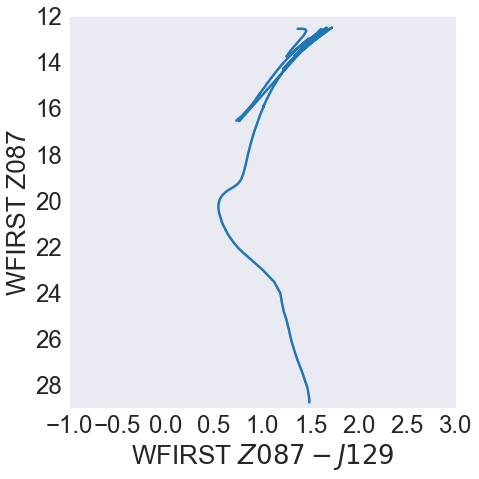

In [18]:

fig, ax = plt.subplots(1,1, figsize=[7,7])
mpl.rcParams.update({'font.size': 18})
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 



if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
    print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
else:    
    #CFHT magnitudes
    sample_gmags = inter_gmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_imags = inter_imags(sample_lowmasses) + d_mod #distance modulus Pal5
    #WFIRST magnitudes
    sample_Rmags = inter_Rmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Zmags = inter_Zmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Ymags = inter_Ymags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Jmags = inter_Jmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Hmags = inter_Hmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Fmags = inter_Fmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Wmags = inter_Wmags(sample_lowmasses) + d_mod #distance modulus Pal5

    
    
        #resample to have 10xmire stars 
        
if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
    print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
else:    
    #CFHT magnitudes
    sample_gmags_m5 = inter_gmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_imags_m5 = inter_imags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    #WFIRST magnitudes
    sample_Rmags_m5 = inter_Rmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Zmags_m5 = inter_Zmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Ymags_m5 = inter_Ymags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Jmags_m5 = inter_Jmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Hmags_m5 = inter_Hmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Fmags_m5 = inter_Fmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5
    sample_Wmags_m5 = inter_Wmags(sample_lowmasses_m5) + d_mod #distance modulus Pal5

    
    
        #resample to have 10xmire stars         

if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
    print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
else:    
    #CFHT magnitudes
    sample_gmags_m10 = inter_gmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_imags_m10 = inter_imags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    #WFIRST magnitudes
    sample_Rmags_m10 = inter_Rmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Zmags_m10 = inter_Zmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Ymags_m10 = inter_Ymags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Jmags_m10 = inter_Jmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Hmags_m10 = inter_Hmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Fmags_m10 = inter_Fmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    sample_Wmags_m10 = inter_Wmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5
    
   # sample_Zmags_m10 = inter_Zmags(sample_lowmasses_m10) + d_mod #distance modulus Pal5

    ### SUM up histogram ###

    mag_array = np.linspace(10,35,1000)
    cum_stars_R = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Rmags < mag_array[i])[0])
        #print(no)
        cum_stars_R[i] = no

    mag_array = np.linspace(10,35,1000)
    cum_stars_Z = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Zmags < mag_array[i])[0])
        #print(no)
        cum_stars_Z[i] = no
        
    mag_array = np.linspace(10,35,1000)
    cum_stars_Z_m5 = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Zmags_m5 < mag_array[i])[0])
        #print(no)
        cum_stars_Z_m5[i] = no      
        
    mag_array = np.linspace(10,35,1000)
    cum_stars_Z_m10 = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Zmags_m10 < mag_array[i])[0])
        #print(no)
        cum_stars_Z_m10[i] = no    

    nstars_wfirst = len(np.where((sample_Zmags < MAG_LIMIT-D_MOD_GALAX))[0])
    nstars_wfirst_m5 = len(np.where((sample_Zmags_m5 < MAG_LIMIT-D_MOD_GALAX))[0])
    nstars_wfirst_m10 = len(np.where((sample_Zmags_m10 < MAG_LIMIT-D_MOD_GALAX))[0])
 

    ax.plot(wfirst_Z[:-1]-wfirst_J[:-1] , wfirst_Z[:-1]+ d_mod, linewidth=2.5)#wfirst_R[:-1] + d_mod, linewidth=2.5)
    ax.set_ylim([29,12])
   # ax[0].set_title('Isochrone from PARSEC')
    #ax.fill_between([-1,4],28.4-dist_mod_And,28.64-dist_mod_And,color='black', alpha=0.3)
   # ax.text(-0.8,29.9-dist_mod_And, 'd = 785 kpc (M31), WFIRST', fontsize=26)
   # ax.fill_between([-1,4],28.4,28.64,color='black', alpha=0.3)
    #ax.text(-0.8,27.9, 'd = 23.5 kpc (Pal 5), WFIRST', fontsize=16)
    ax.set_xlim([-1,3])
    ax.set_ylabel('WFIRST Z087')
    ax.set_xlabel('WFIRST $Z087 - J129$')
   # ax[1,0].fill_between([-1,4],27.0-13.5,27.25-13.5,color='black', alpha=0.1)


#     ax[1,1].plot(mag_array+7.6, cum_stars_Z)
#     ax[1,1].plot(mag_array+7.6, cum_stars_Z*10, color='steelblue',linestyle='--')
#     ax[1,1].set_yscale('log')
#     ax[1,1].set_xlabel('WFIRST Z062')
#     ax[1,1].set_title("At M31's distance")
#     ax[1,1].set_ylabel('Cum. no. stars')
#     ax[1,1].fill_between([27.05,27.25],1,300000,color='steelblue', alpha=0.3)
#     ax[1,1].text(25.6,10**3, 'WFIRST, guest obs.', fontsize=14)
#     ax[1,1].set_ylim([0,300000])
    fig.tight_layout()
    fig.savefig('../figures/FIG1_IAU.pdf',  rasterized=True)
    #fig.savefig('FIG1_CFHT_WFIRST_IMF3000_500Myr_z0.pdf',  rasterized=True)
#G-band limiting mag: 25.5 with S/N=10 
#https://urldefense.proofpoint.com/v2/url?u=https-3A__www.noao.edu_meetings_m31_files_Martin-5FPAndAS.pdf-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=fMUmbThfQiJFFZ2JYFKq22-Ldy5mlRVPJfBynveBrUg&e= #PUT SDSS and PANDAS limits on (same g-band) 
    
    
    
    
    
    
    


#G-band limiting mag: 25.5 with S/N=10 
#https://urldefense.proofpoint.com/v2/url?u=https-3A__www.noao.edu_meetings_m31_files_Martin-5FPAndAS.pdf-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=fMUmbThfQiJFFZ2JYFKq22-Ldy5mlRVPJfBynveBrUg&e= #PUT SDSS and PANDAS limits on (same g-band) 

In [19]:
D_MOD_PAL5

16.8553

In [20]:
d_mod = 16.8553 
dist_mod_And = 7.66# fa

In [21]:
NUMSTARS={}

In [22]:
import astropy.units as u

d=([0.5, 0.6, 0.77, 0.8, 0.9, 1.0, 2., 2.5, 3., 3.5, 4., 4.5, 5.])*u.Mpc
dmods=5*np.log10(d.to(u.pc)/(10*u.pc)).value
maglimits=[27.15, 28.54]

NSIM= 100_000 #TOTAL NUMBER OF STARS TO SIMULATE


for D_MOD_GALAX in dmods:
    for MAG_LIMIT in maglimits:
        
            sample_lowmasses=sample_from_powerlaw(-0.5, xmin=np.min(cfht_mini), xmax=np.max(cfht_mini), nsample=int(NSIM))

        
            
            
            inter_gmags = interp.interp1d(cfht_mini, cfht_gmag)
            inter_imags = interp.interp1d(cfht_mini, cfht_imag)
            inter_Rmags = interp.interp1d(wfirst_mini, wfirst_mags[:,0])
            inter_Zmags = interp.interp1d(wfirst_mini, wfirst_mags[:,1])
            inter_Ymags = interp.interp1d(wfirst_mini, wfirst_mags[:,2])
            inter_Jmags = interp.interp1d(wfirst_mini, wfirst_mags[:,3])
            inter_Hmags = interp.interp1d(wfirst_mini, wfirst_mags[:,4])
            inter_Fmags = interp.interp1d(wfirst_mini, wfirst_mags[:,5])
            inter_Wmags = interp.interp1d(wfirst_mini, wfirst_mags[:,6])
            
            

            if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
                print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
            else:    
                #CFHT magnitudes
                sample_gmags = inter_gmags(sample_lowmasses) + d_mod  #distance modulus Pal5
                sample_imags = inter_imags(sample_lowmasses) + d_mod #distance modulus Pal5
                #WFIRST magnitudes
                sample_Rmags = inter_Rmags(sample_lowmasses) + d_mod  #distance modulus Pal5
                sample_Zmags = inter_Zmags(sample_lowmasses)+ d_mod #distance modulus Pal5
                sample_Ymags = inter_Ymags(sample_lowmasses)  + d_mod 
                sample_Jmags = inter_Jmags(sample_lowmasses)+ d_mod  #distance modulus Pal5
                sample_Hmags = inter_Hmags(sample_lowmasses) + d_mod #distance modulus Pal5
                sample_Fmags = inter_Fmags(sample_lowmasses)+ d_mod #distance modulus Pal5
                sample_Wmags = inter_Wmags(sample_lowmasses) + d_mod #distance modulus Pal5
                
                #renormalize the luminosity function by computing a normalization factor
                num_20_23= len(sample_gmags[np.logical_and(sample_gmags>20, sample_gmags<23)])
                print ('number of stars between 20 and 23 G mag {}'.format( num_20_23))
                
                norm= 3000/num_20_23
                
                



                ### SUM up histogram ###

                mag_array = np.linspace(10,35,1000)
                cum_stars_R = np.zeros(len(mag_array))
                
                for i in range(len(mag_array)):
                    no = len(np.where(sample_Rmags < mag_array[i])[0])
                    #print(no)
                    cum_stars_R[i] = no

                mag_array = np.linspace(10,35,1000)
                cum_stars_Z = np.zeros(len(mag_array))
                for i in range(len(mag_array)):
                    no = len(np.where(sample_Zmags < mag_array[i])[0])
                    #print(no)
                    cum_stars_Z[i] = no
                    
                #multiply by the scale factor
                dist_mod_And = D_MOD_GALAX-d_mod 
               
                nstars_wfirst = (len(np.where((sample_Zmags < MAG_LIMIT-dist_mod_And  ))[0])*   num_20_23)/NSIM
               


        
           
            
            print ('------------------------------------------------------------')
            print ('mag limit {} '.format(MAG_LIMIT))
            print ('distance modulus  {}'.format(D_MOD_GALAX))
            print ('Pal 5  {}'.format( nstars_wfirst))
            #print ('5 Pal 5  {}'.format(nstars_wfirst_m5))
            #print ('10 Pal 5  {}'.format(nstars_wfirst_m10
            k='mlimit{:.2f} dmod{:.2f}'.format(MAG_LIMIT, D_MOD_GALAX)
            NUMSTARS[k]=nstars_wfirst
        
        




            #G-band limiting mag: 25.5 with S/N=10 
            #https://urldefense.proofpoint.com/v2/url?u=https-3A__www.noao.edu_meetings_m31_files_Martin-5FPAndAS.pdf-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=fMUmbThfQiJFFZ2JYFKq22-Ldy5mlRVPJfBynveBrUg&e= #PUT SDSS and PANDAS limits on (same g-band) 

number of stars between 20 and 23 G mag 15249
------------------------------------------------------------
mag limit 27.15 
distance modulus  23.494850021680094
Pal 5  673.85331
number of stars between 20 and 23 G mag 15190
------------------------------------------------------------
mag limit 28.54 
distance modulus  23.494850021680094
Pal 5  2359.3108
number of stars between 20 and 23 G mag 15086
------------------------------------------------------------
mag limit 27.15 
distance modulus  23.89075625191822
Pal 5  403.24878
number of stars between 20 and 23 G mag 14857
------------------------------------------------------------
mag limit 28.54 
distance modulus  23.89075625191822
Pal 5  1693.10372
number of stars between 20 and 23 G mag 15176
------------------------------------------------------------
mag limit 27.15 
distance modulus  24.43245362586241
Pal 5  197.59152
number of stars between 20 and 23 G mag 15111
------------------------------------------------------------
mag l

In [23]:
NUMSTARS

{'mlimit27.15 dmod23.49': 673.85331,
 'mlimit28.54 dmod23.49': 2359.3108,
 'mlimit27.15 dmod23.89': 403.24878,
 'mlimit28.54 dmod23.89': 1693.10372,
 'mlimit27.15 dmod24.43': 197.59152,
 'mlimit28.54 dmod24.43': 1082.85426,
 'mlimit27.15 dmod24.52': 190.6663,
 'mlimit28.54 dmod24.52': 1013.37776,
 'mlimit27.15 dmod24.77': 145.74054,
 'mlimit28.54 dmod24.77': 778.77,
 'mlimit27.15 dmod25.00': 138.2884,
 'mlimit28.54 dmod25.00': 595.12944,
 'mlimit27.15 dmod26.51': 69.19414,
 'mlimit28.54 dmod26.51': 128.62542,
 'mlimit27.15 dmod26.99': 54.65824,
 'mlimit28.54 dmod26.99': 97.40145,
 'mlimit27.15 dmod27.39': 51.01152,
 'mlimit28.54 dmod27.39': 77.16682,
 'mlimit27.15 dmod27.72': 20.28224,
 'mlimit28.54 dmod27.72': 67.72141,
 'mlimit27.15 dmod28.01': 18.4284,
 'mlimit28.54 dmod28.01': 61.93896,
 'mlimit27.15 dmod28.27': 13.38321,
 'mlimit28.54 dmod28.27': 54.3526,
 'mlimit27.15 dmod28.49': 14.06312,
 'mlimit28.54 dmod28.49': 52.173}

In [24]:
filename=isochrone_path+'/number_of_stars_pal5.pkl'
import pickle
with open(filename, 'wb') as file:
   pickle.dump(NUMSTARS,file)

number of stars between 20 and 23 G mag 15345


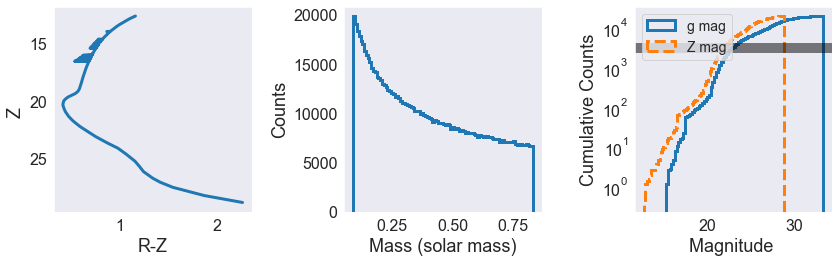

In [25]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

D_MOD_GALAX= 24.5153
MAG_LIMIT=28.15

NSIM=100_0000
sample_lowmasses=sample_from_powerlaw(-0.5, xmin=np.min(cfht_mini), xmax=np.max(cfht_mini), nsample=int(NSIM))

        
            

inter_gmags = interp.interp1d(cfht_mini, cfht_gmag)
inter_imags = interp.interp1d(cfht_mini, cfht_imag)
inter_Rmags = interp.interp1d(wfirst_mini, wfirst_mags[:,0])
inter_Zmags = interp.interp1d(wfirst_mini, wfirst_mags[:,1])
inter_Ymags = interp.interp1d(wfirst_mini, wfirst_mags[:,2])
inter_Jmags = interp.interp1d(wfirst_mini, wfirst_mags[:,3])
inter_Hmags = interp.interp1d(wfirst_mini, wfirst_mags[:,4])
inter_Fmags = interp.interp1d(wfirst_mini, wfirst_mags[:,5])
inter_Wmags = interp.interp1d(wfirst_mini, wfirst_mags[:,6])

#renormalize the luminosity function by computing a normalization factor
num_20_23= len(sample_gmags[np.logical_and(sample_gmags>20, sample_gmags<23)])
print ('number of stars between 20 and 23 G mag {}'.format( num_20_23))

norm= 3000/num_20_23





### SUM up histogram ###

mag_array = np.linspace(10,35,1000)
cum_stars_R = np.zeros(len(mag_array))

for i in range(len(mag_array)):
    no = len(np.where(sample_Rmags < mag_array[i])[0])
    #print(no)
    cum_stars_R[i] = no

mag_array = np.linspace(10,35,1000)
cum_stars_Z = np.zeros(len(mag_array))
for i in range(len(mag_array)):
    no = len(np.where(sample_Zmags < mag_array[i])[0])
    #print(no)
    cum_stars_Z[i] = no

#multiply by the scale factor
dist_mod_And = D_MOD_GALAX-d_mod 

nstars_wfirst = (len(np.where((sample_Zmags < MAG_LIMIT-dist_mod_And  ))[0])*   num_20_23)/NSIM


#print ('10 Pal 5  {}'.format(nstars_wfirst_m10))

#plot the isochrone
sorted_z= np.argsort(sample_Zmags)
ax[0].plot( (sample_Rmags-sample_Zmags)[sorted_z], sample_Zmags[sorted_z], linewidth=3 )
ax[0].invert_yaxis()
ax[0].set(xlabel='R-Z', ylabel='Z ')


ax[1].hist(sample_lowmasses,  histtype='step', lw=3, bins='auto')
ax[1].set(xlabel='Mass (solar mass)', ylabel='Counts')


#plot the normalized number of stars 
(counts, bins) = np.histogram(sample_gmags, bins='auto')
ax[-1].hist(bins[:-1], bins, weights=norm*counts , histtype='step', lw=3, cumulative=True, label= 'g mag')


#plot the normalized number of stars 
(counts, bins) = np.histogram(sample_Zmags, bins='auto')
ax[-1].hist(bins[:-1], bins, weights=norm*counts , histtype='step', lw=3, \
            cumulative=True, label='Z mag', linestyle= '--')
ax[-1].axhline(3000, c='k', linewidth=10, alpha=0.5)
ax[-1].set(xlabel= 'Magnitude ', ylabel='Cumulative Counts', yscale='log')
ax[-1].legend(fontsize=14, loc='upper left')
plt.tight_layout()

for a in ax:
    a.minorticks_on()
plt.tight_layout()
plt.savefig(path_plot+'/isochrones_illustration.pdf')

In [26]:
path_plot+'/isochrones_illustration.pdf'

'/users/caganze/research/stellarstreams/figures/paper//isochrones_illustration.pdf'

In [27]:
nstars_wfirst_m5

973

In [28]:
nstars_wfirst

67.717485

In [29]:
hgjk

NameError: name 'hgjk' is not defined

In [ ]:
#len(cfht_imag)
#sample_Zmags
#np.min(wfirst_Z + d_mod+12)
#Diustac factor to get 20 Mpc away : 23*870 = 20 Mpc. 

#Factor of 1000 further away is 15 mags 
27.15-14.6975

In [ ]:
###FUrthest distance we can see Pal 5 with WFIRST
max_R = np.min(wfirst_R)
print(max_R + d_mod) 

#A factor of 100 furtger away yields 10 more mags
print(max_R + d_mod + 10) 

dfac_uplim = 870#435#33#andr # factor you move distance farther out by
d_pal5 = 23500 # kpc
mod_pal5 = 5*np.log10(d_pal5/10)
mod =  5*np.log10(d_pal5 * dfac_uplim/10)
mag_fac_uplim = mod - mod_pal5
print(mag_fac_uplim)

In [ ]:
#np.linspace(1,200,200)

In [ ]:
##WFIRST can see to a limiting Z mag of 27.15 with guest observer program

#10 Mpc is a factor of 435 farther than Pal 5 
#andromeda is a factor of 33 farther in diustanc 
#make dfac into array

#dfac = np.array([1,5,10,15,33,40,50,60,70,80,100,120,150])#,200])#,435]) #use these for the no. stars per distance plot 

dfac = np.linspace(1,1000,1000)

#dfac = 33#435#33#andr # factor you move distance farther out by
d_pal5 = 23500 # kpc
mod_pal5 = 5*np.log10(d_pal5/10)
mag_fac = np.zeros(len(dfac))
for i in range(len(dfac)):
    mod =  5*np.log10(d_pal5 * dfac[i]/10)
    mag_fac[i] = mod - mod_pal5
    
#print(mag_fac)


#mag_array
#cum_stars_Z

In [ ]:
#print(mag_array+7.6)
#print(cum_stars_Z)
#mag_array

In [ ]:
# mag_ind = np.where((mag_array + mag_fac[6] > 26.9) & (mag_array + mag_fac[6] < 27.3))
# #print(mag_array + mag_fac[6])
# #print(mag_ind )
# cum_stars_Z[mag_ind]
28.65

In [ ]:
dfac = np.linspace(1,1000,1000)
no_stars = np.zeros(len(dfac))
for i in range(len(dfac)):
    mag_ind = np.where((mag_array + mag_fac[i] > 28.55) & (mag_array + mag_fac[i] <28.75))
 #   print(mag_ind[0][0])
 #   print(cum_stars_Z[mag_ind[0][0]])
    no_stars[i] = cum_stars_Z[mag_ind[0][0]]
    
#no_stars

In [ ]:
#More massive Pal 5 

dfac_m5 = np.linspace(1,1000,1000)
no_stars_m5 = np.zeros(len(dfac_m5))
for i in range(len(dfac_m5)):
    mag_ind = np.where((mag_array + mag_fac[i] > 28.55) & (mag_array + mag_fac[i] < 28.75))
 #   print(mag_ind[0][0])
 #   print(cum_stars_Z[mag_ind[0][0]])
    no_stars_m5[i] = cum_stars_Z_m5[mag_ind[0][0]]
    
#no_stars

In [ ]:
#More massive Pal 5 

dfac_m10 = np.linspace(1,1000,1000)
no_stars_m10 = np.zeros(len(dfac_m10))
for i in range(len(dfac_m10)):
    mag_ind = np.where((mag_array + mag_fac[i] > 28.55) & (mag_array + mag_fac[i] < 28.75))
 #   print(mag_ind[0][0])
 #   print(cum_stars_Z[mag_ind[0][0]])
    no_stars_m10[i] = cum_stars_Z_m10[mag_ind[0][0]]
    
#no_stars

In [ ]:
distance = np.arange(0,10,0.1)
Pal5_stars_wfirst = np.linspace(20,0,100)
Pal5_x10_stars_wfirst =np.linspace(200,0,100)

In [ ]:
#####Making arrays for counting error markers
#### This is for streams of x amount of stars where C_err >15 at a given distance
#### I get this from WFIRST.ipynb notebook by estimateing how many stars I need for 
#### C_err > 15 at a given distance, this is for all Fe at Rgc  = 35 kpc 

C_err = np.array([])
C_err_dist = np.array([785,3500,7180])


In [ ]:
##See C_err.ipynb
n_stars_Cerr15= np.genfromtxt("n_stars_Cerr15_Z2854.txt")
n_stars_Cerr15_m5= np.genfromtxt("n_stars_Cerr15_m5_Z2854.txt")
n_stars_Cerr15_m10= np.genfromtxt("n_stars_Cerr15_m10_Z2854.txt")

# n_stars_Cerr15= np.genfromtxt("n_stars_Cerr15_Z2854_July.txt")
# n_stars_Cerr15_m5= np.genfromtxt("n_stars_Cerr15_m5_Z2854_July.txt")
# n_stars_Cerr15_m10= np.genfromtxt("n_stars_Cerr15_m10_Z2854_July.txt")

#distance_Cerr15 = np.linspace(1000,10000,100) #kpc
d_M31 = 785
distance_Cerr15 = np.linspace(d_M31,30*d_M31,100)

In [ ]:
####Ben's fields 

n_stars_Cerr15_Ben = np.genfromtxt("n_stars_Cerr15_Z2854_Ben.txt")
n_stars_Cerr15_m5_Ben = np.genfromtxt("n_stars_Cerr15_m5_Z2854_Ben.txt")
n_stars_Cerr15_m10_Ben = np.genfromtxt("n_stars_Cerr15_m10_Z2854_Ben.txt")

# n_stars_Cerr10_Ben = np.genfromtxt("n_stars_Cerr10_Z2854_Ben.txt")
# n_stars_Cerr10_m5_Ben = np.genfromtxt("n_stars_Cerr10_m5_Z2854_Ben.txt")
# n_stars_Cerr10_m10_Ben = np.genfromtxt("n_stars_Cerr10_m10_Z2854_Ben.txt")

# n_stars_Cerr5_Ben = np.genfromtxt("n_stars_Cerr5_Z2854_Ben.txt")
# n_stars_Cerr5_m5_Ben = np.genfromtxt("n_stars_Cerr5_m5_Z2854_Ben.txt")
# n_stars_Cerr5_m10_Ben = np.genfromtxt("n_stars_Cerr5_m10_Z2854_Ben.txt")

# n_stars_Cerr7_Ben = np.genfromtxt("n_stars_Cerr7_Z2854_Ben.txt")
# n_stars_Cerr7_m5_Ben = np.genfromtxt("n_stars_Cerr7_m5_Z2854_Ben.txt")
# n_stars_Cerr7_m10_Ben = np.genfromtxt("n_stars_Cerr7_m10_Z2854_Ben.txt")

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(7,7))
mpl.rcParams.update({'font.size': 24})
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

axes.set_title('1h exposure', fontsize=22)
axes.plot(dfac_m10 * d_pal5/1000 , no_stars_m10, label='10 x Pal 5', linestyle='--', color='steelblue', linewidth=3)
axes.plot(distance_Cerr15,n_stars_Cerr15_m10_Ben,color='black',  linestyle='--',linewidth=1.5,alpha = 0.7,label='$C_{err} = 15$')#,label='10 x Pal 5, $C_{err} = 15$')
axes.plot(3500,950,color='black', linestyle = 'none',marker='*',markersize=10, alpha=0.7)
axes.plot(distance_Cerr15,n_stars_Cerr15_m10,color='maroon',  linestyle='--',linewidth=1.5,label='$C_{err} = 15$')
axes.plot(7800,190,color='maroon', linestyle = 'none',marker='*',markersize=10, alpha=0.8)


#axes.plot(6000,750,color='black', linestyle = 'none',marker='*',markersize=10, alpha=0.8)



axes.plot(dfac_m5 * d_pal5/1000 , no_stars_m5, label='5 x Pal 5', linestyle=':', color='steelblue', linewidth=3)
axes.plot(distance_Cerr15,n_stars_Cerr15_m5_Ben,color='black',  linestyle=':',linewidth=1.5,alpha = 0.7,label='$C_{err} = 15$')#,label='10 x Pal 5, $C_{err} = 15$')
axes.plot(1700,1050,color='black', linestyle = 'none',marker='*',markersize=10, alpha=0.7)

axes.plot(distance_Cerr15,n_stars_Cerr15_m5,color='maroon',  linestyle=':',linewidth=1.5, label = '$C_{err} = 15$')
axes.plot(6200,170,color='maroon', linestyle = 'none',marker='*',markersize=10, alpha=0.8)



axes.plot(dfac * d_pal5/1000 , no_stars, label='Pal 5', color= 'steelblue', linewidth=3)#,label='10 x Pal 5', color='maroon', linestyle='--')

axes.plot(distance_Cerr15,n_stars_Cerr15_Ben,color='black',linewidth=1.5,alpha = 0.7,label='$C_{err} = 15$')#,label='10 x Pal 5, $C_{err} = 15$')
axes.plot(1050,710,color='black', linestyle = 'none',marker='*',markersize=10, alpha=0.7)
axes.plot(distance_Cerr15,n_stars_Cerr15,color='maroon', linewidth=1.5,label='$C_{err} = 15$')
axes.plot(1750,190,color='maroon', linestyle = 'none',marker='*',markersize=10, alpha=0.8)


#axes.plot(1000,890,color='black', linestyle = 'none',marker='*',markersize=10, alpha=0.8)



axes.set_xlabel('Distance [kpc]')
axes.fill_between([48,51],0,2000000,color='black', alpha=0.3)
axes.text(50,4500, 'LMC', fontsize=16,color='black')
axes.fill_between([770,800],0,2000000,color='black', alpha=0.3)
axes.text(700,10000, 'M31', fontsize=16,color='black')
axes.fill_between([3400,3600],0,2000000,color='black', alpha=0.3)
axes.text(2000, 50000, 'Cen A', fontsize=16,color='black')
axes.fill_between([7000,7360],0,2000000,color='black', alpha=0.3)
axes.text(4500, 10000, 'M101', fontsize=16,color='black')


#### I get this from WFIRST_paper_figure.ipynb notebook by estimateing how mant stars I need for 
#### C_err > 15 at a given distance 
#axes.plot(785, 120, marker='*', color='maroon',markersize=14,linestyle='none',label='Pal 5: $C_{err}>15$') #for counting err >15
#####


#axes.fill_between([0,20060],0,80,color='black', alpha=0.1)
#axes.text(30, 42, '10 x Pal 5: not detectable', color='black',fontsize=16)
#axes.fill_between([0,20060],0,30,color='black', alpha=0.3)
#axes.text(30, 5, 'Pal 5: not detectable', color='black',fontsize=16)
axes.set_ylabel('No. resolved stars')
axes.set_xlim([23,24000])
axes.set_yscale('log')
axes.set_xscale('log')
axes.set_ylim([1,400000])
axes.legend(fontsize=14, loc=('lower left'))
fig.tight_layout()


fig.savefig('../figures/Fig4_Z2854_crowd02.pdf', dpi= 400, rasterized=True)


In [ ]:
fig,axes = plt.subplots(1,1,figsize=(7,7))
mpl.rcParams.update({'font.size': 24})
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

axes.set_title('1h exposure', fontsize=22)
axes.plot(dfac_m10 * d_pal5/1000 , no_stars_m10, label='10 x Pal 5', linestyle='--', color='steelblue', linewidth=3)
axes.plot(distance_Cerr15,n_stars_Cerr15_m10_Ben,color='black',  linestyle='--',linewidth=1.5,alpha = 0.7)#,label='10 x Pal 5, $C_{err} = 15$')
axes.plot(3500,950,color='black', linestyle = 'none',marker='o',markersize=8, markeredgewidth=2, fillstyle='none')

axes.plot(distance_Cerr15,n_stars_Cerr15_m10,color='maroon',  linestyle='--',linewidth=1.5)
axes.plot(7800,190,color='maroon', linestyle = 'none',marker='*',markersize=10, alpha=0.8)
#axes.plot(9300,130,color='maroon', linestyle = 'none',marker='*',markersize=10, alpha=0.8)



axes.plot(dfac_m5 * d_pal5/1000 , no_stars_m5, label='5 x Pal 5', linestyle=':', color='steelblue', linewidth=3)
axes.plot(distance_Cerr15,n_stars_Cerr15_m5_Ben,color='black',  linestyle=':',linewidth=1.5,alpha = 0.7)#,label='10 x Pal 5, $C_{err} = 15$')
axes.plot(1700,1050,color='black', linestyle = 'none',marker='o',markersize=8, markeredgewidth=2, fillstyle='none')

axes.plot(distance_Cerr15,n_stars_Cerr15_m5,color='maroon',  linestyle=':',linewidth=1.5)
axes.plot(6200,170,color='maroon', linestyle = 'none',marker='*',markersize=10, alpha=0.8)



axes.plot(dfac * d_pal5/1000 , no_stars, label='Pal 5', color= 'steelblue', linewidth=3)#,label='10 x Pal 5', color='maroon', linestyle='--')

axes.plot(distance_Cerr15,n_stars_Cerr15_Ben,color='black',linewidth=1.5,alpha = 0.7)#,label='10 x Pal 5, $C_{err} = 15$')
circle,= axes.plot(1050,710,color='black', linestyle = 'none', marker='o', markersize=8, markeredgewidth=2, fillstyle='none')
axes.plot(distance_Cerr15,n_stars_Cerr15,color='maroon', linewidth=1.5)
star, = axes.plot(1750,190,color='maroon', linestyle = 'none',marker='*',markersize=10, alpha=0.8)
#star, = axes.plot(2600,125,color='maroon', linestyle = 'none',marker='*',markersize=10, alpha=0.8)



axes.set_xlabel('Distance [kpc]')
axes.fill_between([48,51],0,2000000,color='black', alpha=0.3)
axes.text(50,4500, 'LMC', fontsize=16,color='black')
axes.fill_between([770,800],0,2000000,color='black', alpha=0.3)
axes.text(800,20000, 'M31', fontsize=16,color='black')
axes.fill_between([3400,3600],0,2000000,color='black', alpha=0.3)
axes.text(2050, 9000, 'Cen A', fontsize=16,color='black')
axes.fill_between([7000,7360],0,2000000,color='black', alpha=0.3)
axes.text(4500, 5000, 'M101', fontsize=16,color='black')



axes.set_ylabel('No. resolved stars')
axes.set_xlim([23,24000])
axes.set_yscale('log')
axes.set_xscale('log')
axes.set_ylim([1,400000])
#leg1 = axes.legend(fontsize=14, loc=('lower left'))
#leg2 = axes.legend([circle,star],['(w. contamination): C$_{err}$ = 15','(no contamination): C$_{err}$ = 15'],loc='upper right', fontsize=14)
#plt.setp(leg2.get_texts(), color='maroon')
#axes.add_artist(leg1)
fig.tight_layout()
#fig.savefig('Fig4_Z2854_test.pdf', dpi= 400, rasterized=True)

fig.savefig('../figures/Fig4_IAU_FeHcut.png')#pdf', dpi= 400, rasterized=True)



In [ ]:
d_mod_pal5 = 5*np.log10(23500/10) 

In [ ]:
600*23

## Recalculate length and widht of streams

I assume the following initial params for Pal 5:

Length = 8.5 kpc,
Width= 0.058 kpc


In [ ]:
pal5_width = 0.058 #kpc
pal5_length = 8.5 #kpc

## V$_{circ}$ correction

In [ ]:
#### Correct for Andromeda tides ####
v_circ_MW = 220 #km/s
v_circ_M31 = 250 #km/s Chemin et al 2009 HI emission
v_corr =  (1/(250/220)**(2/3.)) #r_t smaller as the tidal field from M31 is larger 

# This should go into both length and width (their smaller)

## Mass correction

In [ ]:
### Correct for mass of cluster ####
m_corr = (10)**(1/3.)
m_corr_m5 = (5)**(1/3.)
#The more massive stream should be longer and wider by this factor

## R$_{GC}$ and T$_{\psi}$ corrections

In [ ]:
##### Correct for various locations in Galaxy
R_p = np.array([15,35,55]) # kpc we use these three different R_GCs

Rp_corr = np.zeros(len(R_p))
for i in range(len(R_p)):
    Rp_corr[i] = (R_p[i]/R_p[0])**(2/3.) #gets longer and wider width distance 

### Correct for the fact that T_psi changes (less completed orbits)
##THIS IS THE ANGULAR EXTENT
psi_corr  = np.zeros(len(R_p))
for i in range(len(R_p)):
    psi_corr[i] = (R_p[0]/R_p[i]) #angular length gets smaller.


## For surface brightness calculations

In [ ]:
# Pal 5 like stream:

#### R_GC = 15 kpc ####
print('m: Pal5')
print('R_GC = 15 kpc')
w_15 = pal5_width * v_corr * Rp_corr[0] 
l_15 = pal5_length * v_corr * Rp_corr[0] #* psi_corr[0]
print('w = ' +  str(np.round(w_15,3)) + ' kpc')
print('')

#### R_GC = 35 kpc ####
print('R_GC = 35 kpc')
w_35 = pal5_width * v_corr * Rp_corr[1] 
l_35 = pal5_length * v_corr * Rp_corr[1] #* psi_corr[1]
print('w = ' +  str(np.round(w_35,3)) + ' kpc')
print('')

#### R_GC = 55 kpc ####
print('R_GC = 55 kpc')
w_55 = pal5_width * v_corr * Rp_corr[2] 
l_55 = pal5_length * v_corr * Rp_corr[2] 
print('w = ' +  str(np.round(w_55,3)) + ' kpc')
print('')

print('')
print('')
# Pal 5 like stream:

#### R_GC = 15 kpc ####
print('m:10 x Pal5') 
print('R_GC = 15 kpc')
w = pal5_width * m_corr * v_corr * Rp_corr[0] 
l = pal5_length * m_corr * v_corr * Rp_corr[0] #* psi_corr[0]
print('w = ' +  str(np.round(w,3)) + ' kpc')
print('')

#### R_GC = 35 kpc ####
print('R_GC = 35 kpc')
w = pal5_width * m_corr * v_corr * Rp_corr[1] 
l = pal5_length * m_corr * v_corr * Rp_corr[1] #* psi_corr[1]
print('w = ' +  str(np.round(w,3)) + ' kpc')
print('')

#### R_GC = 55 kpc ####
print('R_GC = 55 kpc')
w = pal5_width * m_corr* v_corr * Rp_corr[2] 
l = pal5_length * m_corr * v_corr * Rp_corr[2] 
print('w = ' +  str(np.round(w,3)) + ' kpc')
print('')

In [ ]:
# #Because I am computing arcs of circle based on angles:
# circumfr = 2*np.pi*R_p
# # At R_p = 15 kpc, we want the stream to be 7.81 kpc in Andromeda, 
# #so I need to figure out what fraction of the circumfrence this corresponds to
# #this fraction is ------- 1/11.08 ------
# lengths_kpc = np.array([7.81,13.73, 18.56]) # Without correcting for angle (T_psi)
# lengths_kpc_m10 = lengths_kpc  * m_corr

# #Now we correct for angle! Meaning a factor of R_p less in angular extent. 
# lengths_kpc_ang = np.array([l_15 /(R_p[0]/R_p[0]),\
#                             l_35/(R_p[1]/R_p[0]),\
#                             l_55/(R_p[2]/R_p[0])])# Without correcting for angle (T_psi)
# lengths_kpc_m10_ang = lengths_kpc_ang * m_corr
# print('Lengths for pal-5like stream at 3 radii: ')
# print(lengths_kpc_ang)
# print('')
# print('Lengths for 10x mass stream at 3 radii: ')
# print(lengths_kpc_m10_ang)
# print('')


# print('sanity check for circle arc plotting')
# circ_corr = np.array([12.065,37.37,68.28]) #just to get from full circle down to 7.81 kpc
# print(circumfr / circ_corr) #Only doing this because I am plotting as a fraction of a circle

# #Do it for more massive stream to
# print(circumfr / circ_corr*m_corr) #Only doing this because I am plotting as a fraction of a circle
# #lengths_kpc 


In [ ]:
######### NEW LENGTH CALC ####### 02/25/19
#Because I am computing arcs of circle based on angles:
circumfr = 2*np.pi*R_p

v_corr_L = (250/220)**(1/3.)


lengths_kpc = np.array([8.5,8.5, 8.5])*v_corr_L
lengths_kpc_m5 = lengths_kpc  * m_corr_m5
lengths_kpc_m10 = lengths_kpc  * m_corr

#Now we correct for angle! Meaning a factor of R_p less in angular extent. 
lengths_kpc_ang = np.array([l_15 *(R_p[0]/R_p[0])**(-1/3),\
                            l_35*(R_p[1]/R_p[0])**(-1/3),\
                            l_55*(R_p[2]/R_p[0])**(-1/3)])# Without correcting for angle (T_psi)
lengths_kpc_m5_ang = lengths_kpc_ang * m_corr_m5
lengths_kpc_m10_ang = lengths_kpc_ang * m_corr

print('Lengths for pal-5like stream at 3 radii: ')
print(lengths_kpc_ang)
print('')
print('Lengths for 5x mass stream at 3 radii: ')
print(lengths_kpc_m5_ang)
print('')
print('Lengths for 10x mass stream at 3 radii: ')
print(lengths_kpc_m10_ang)
print('')


print('sanity check for circle arc plotting')
circ_corr = np.array([12.0755,21.24,28.7]) #just to get from full circle down to 7.81 kpc
print(circumfr / circ_corr) #Only doing this because I am plotting as a fraction of a circle

#Do it for more massive stream to
print(circumfr / circ_corr*m_corr) #Only doing this because I am plotting as a fraction of a circle
#lengths_kpc 


In [ ]:
pal5_width = 0.058 #kpc
pal5_length = 8.5 #kpc

In [ ]:
#Calculating areas:
    
    #pal5 like
A15 = 0.053 * 7.80561944 #kpc^2
A35 = 0.094 * 10.3530021
A55 = 0.127 * 12.0364343

#10 x pal 5 like
A15_m10 = 0.115 * 16.81669731
A35_m10 = 0.202 * 22.30486688
A55_m10 = 0.273 * 25.93171166

print('Pal 5 like at 15 kpc')
print(str(A15)+' [kpc^2]')
print('')
print('Pal 5 like at 35 kpc')
print(str(A35)+' [kpc^2]')
print('')
print('Pal 5 like at 55 kpc')
print(str(A55)+' [kpc^2]')
print('')
print('')
print('10 x Pal 5 like at 15 kpc')
print(str(A15_m10)+' [kpc^2]')
print('')
print('10 x Pal 5 like at 35 kpc')
print(str(A35_m10)+' [kpc^2]')
print('')
print('10 x Pal 5 like at 55 kpc')
print(str(A55_m10)+' [kpc^2]')

In [ ]:
import astropy.units as u


###### First correct them all by the fraction to make it right length at R=15 kpc

#I divide 360 by fac to make it 7.81
theta1 = np.array([(90-360/circ_corr[0])*u.deg.to(u.rad),    \
                   (90-360/circ_corr[1])*u.deg.to(u.rad),\
                   (90-360/circ_corr[2])*u.deg.to(u.rad)])  
#sets length of streams, should vary for each 

theta2 = np.array([90*u.deg.to(u.rad),90*u.deg.to(u.rad),90*u.deg.to(u.rad)])


theta1_m5 = np.array([(90-360/circ_corr[0]*m_corr_m5)*u.deg.to(u.rad),    \
                   (90-360/circ_corr[1]*m_corr_m5)*u.deg.to(u.rad),\
                   (90-360/circ_corr[2]*m_corr_m5)*u.deg.to(u.rad)])  
#sets length of streams, should vary for each 

theta2_m5 = np.array([90*u.deg.to(u.rad),90*u.deg.to(u.rad),90*u.deg.to(u.rad)])



theta1_m10 = np.array([(90-360/circ_corr[0]*m_corr)*u.deg.to(u.rad),    \
                   (90-360/circ_corr[1]*m_corr)*u.deg.to(u.rad),\
                   (90-360/circ_corr[2]*m_corr)*u.deg.to(u.rad)])  
#sets length of streams, should vary for each 

theta2_m10 = np.array([90*u.deg.to(u.rad),90*u.deg.to(u.rad),90*u.deg.to(u.rad)])

## Construct Pal 5 like stream

In [ ]:
num_samples = nstars_pandas #this is the amount of stars 

theta = np.zeros([num_samples,len(R_p)])
for i in range(theta.shape[1]):
    theta[:,i] = np.random.uniform(theta1[i], theta2[i], num_samples)#*rand_dist_angle #spread out circle 
#theta = np.linspace(theta1, theta2, num_samples)

#Here I correct width for v_corr
rand_dist_width = np.random.uniform(-pal5_width/2*v_corr, pal5_width/2*v_corr, num_samples) #such that they are rand. spread in angle 
#I have three different distances , r array


#Here I correct width for Rp
dr = np.zeros([num_samples,len(R_p)])
for i in range(dr.shape[1]):
    dr[:,i] = 1 * rand_dist_width * Rp_corr[i] 
    #scale such that width gets udpated based on post in galacy


r_rand = np.ones([num_samples,len(R_p)])*R_p + dr   #R_p here puts the streams at 3 GC radii
x,y = r_rand * np.cos(theta), r_rand * np.sin(theta)

In [ ]:
nstars_pandas

## Construct 5 times more massive stream

In [ ]:
num_samples_m5 = nstars_pandas_m5 #this is the amount of stars 

theta = np.zeros([num_samples_m5,len(R_p)])
for i in range(theta.shape[1]):
    theta[:,i] = np.random.uniform(theta1_m5[i], theta2_m5[i], num_samples_m5)#*rand_dist_angle #spread out circle 
#theta = np.linspace(theta1, theta2, num_samples)

#Here I correct width for v_corr
rand_dist_width = np.random.uniform(-pal5_width/2*v_corr * m_corr_m5, \
                                    pal5_width/2*v_corr * m_corr_m5, num_samples_m5) #such that they are rand. spread in angle 
#I have three different distances , r array


#Here I correct width for Rp
dr = np.zeros([num_samples_m5,len(R_p)])
for i in range(dr.shape[1]):
    dr[:,i] = 1 * rand_dist_width * Rp_corr[i] 
    #scale such that width gets udpated based on post in galacy

    
#Here I correct length for Rp_corr    
r_rand = np.ones([num_samples_m5,len(R_p)])*R_p + dr   #R_p here puts the streams at 3 GC radii
x_m5,y_m5 = r_rand * np.cos(theta), r_rand * np.sin(theta)

## Construct massive stream

In [ ]:
num_samples_m10 = nstars_pandas_m10 #this is the amount of stars 

theta = np.zeros([num_samples_m10,len(R_p)])
for i in range(theta.shape[1]):
    theta[:,i] = np.random.uniform(theta1_m10[i], theta2_m10[i], num_samples_m10)#*rand_dist_angle #spread out circle 
#theta = np.linspace(theta1, theta2, num_samples)

#Here I correct width for v_corr
rand_dist_width = np.random.uniform(-pal5_width/2*v_corr * m_corr, \
                                    pal5_width/2*v_corr * m_corr, num_samples_m10) #such that they are rand. spread in angle 
#I have three different distances , r array


#Here I correct width for Rp
dr = np.zeros([num_samples_m10,len(R_p)])
for i in range(dr.shape[1]):
    dr[:,i] = 1 * rand_dist_width * Rp_corr[i] 
    #scale such that width gets udpated based on post in galacy

    
#Here I correct length for Rp_corr    
r_rand = np.ones([num_samples_m10,len(R_p)])*R_p + dr   #R_p here puts the streams at 3 GC radii
x_m10,y_m10 = r_rand * np.cos(theta), r_rand * np.sin(theta)

In [ ]:
pal5_x_GC15 = x[:,0]
pal5_x_GC35 = x[:,1]
pal5_x_GC55 = x[:,2]

pal5_y_GC15 = y[:,0]
pal5_y_GC35 = y[:,1]
pal5_y_GC55 = y[:,2]


pal5_x_m5_GC15 = x_m5[:,0]
pal5_x_m5_GC35 = x_m5[:,1]
pal5_x_m5_GC55 = x_m5[:,2]

pal5_y_m5_GC15 = y_m5[:,0]
pal5_y_m5_GC35 = y_m5[:,1]
pal5_y_m5_GC55 = y_m5[:,2]


pal5_x_m10_GC15 = x_m10[:,0]
pal5_x_m10_GC35 = x_m10[:,1]
pal5_x_m10_GC55 = x_m10[:,2]

pal5_y_m10_GC15 = y_m10[:,0]
pal5_y_m10_GC35 = y_m10[:,1]
pal5_y_m10_GC55 = y_m10[:,2]

## Plot streams

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(21,7))
#SEE https://urldefense.proofpoint.com/v2/url?u=https-3A__matplotlib.org_api_-5Fas-5Fgen_matplotlib.patches.Arc.html-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=ffrqMhpI1trqCY12xSlWY-DYGts4nQ97OKeMjB5M_5M&e= mpl.rcParams.update({'font.size': 22})
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


axes[0].scatter(x,y, s=1)
axes[0].set_ylim([0,60])
axes[0].set_xlim([-20,40])
axes[0].set_xlabel('[kpc]')
axes[0].set_ylabel('[kpc]')
axes[0].set_title('Pal 5 at various GC radii')
axes[0].set_aspect('equal')


axes[1].scatter(x_m5,y_m5, s=1)
axes[1].set_ylim([0,60])
axes[1].set_xlim([-20,40])
axes[1].set_xlabel('[kpc]')
axes[1].set_ylabel('[kpc]')
axes[1].set_title('10 x Pal 5 at various GC radii')
axes[1].set_aspect('equal')

axes[2].scatter(x_m10,y_m10, s=1)
axes[2].set_ylim([0,60])
axes[2].set_xlim([-20,40])
axes[2].set_xlabel('[kpc]')
axes[2].set_ylabel('[kpc]')
axes[2].set_title('10 x Pal 5 at various GC radii')
axes[2].set_aspect('equal')

fig.tight_layout()
#fig.savefig("GreatCircles_angular_R23rds.png")
###IMPORTANT SOME OF THESE AR CLUSTER STARS?? - no they're not! 


##### DO THIS FOR OTHER BAND!!######

## Now loading M31 PANDAS fields to see if we can detect streams

In [ ]:
from astropy.io.votable import parse_single_table
table_box10 = parse_single_table("/Users/spearson/Desktop/Research/Pal5External/M31_10_20kpc_new.vot").to_table()
table_box30 = parse_single_table("/Users/spearson/Desktop/Research/Pal5External/M31_30_40kpc_new.vot").to_table()
table_box50 = parse_single_table("/Users/spearson/Desktop/Research/Pal5External/M31_50_60kpc_new.vot").to_table()

In [ ]:
#import numpy as np

In [ ]:
d_conv = 785*np.pi/180 #To go from deg to kpc in Andromeda


x_box10 = table_box10['xki']*(-d_conv)
y_box10 = table_box10['eta']*(d_conv)
g_box10 = table_box10['g']
i_box10 = table_box10['i']

x_box30 = table_box30['xki']*(-d_conv)
y_box30 = table_box30['eta']*(d_conv)
g_box30 = table_box30['g']
i_box30 = table_box30['i']

x_box50 = table_box50['xki']*(-d_conv)
y_box50 = table_box50['eta']*(d_conv)
g_box50 = table_box50['g']
i_box50 = table_box50['i']



In [ ]:
#x_box10
print(x_box10.shape)
print(x_box30.shape)
print(x_box50.shape)

In [ ]:
### Make metallicity cuts

index_FeH0_10 = np.where(table_box10['FeH_phot'] < 0)
index_FeH0_30 = np.where(table_box30['FeH_phot'] < 0)
index_FeH0_50 = np.where(table_box50['FeH_phot'] < 0)

index_FeH1_10 = np.where(table_box10['FeH_phot'] < -1.3)
index_FeH1_30 = np.where(table_box30['FeH_phot'] < -1.3)
index_FeH1_50 = np.where(table_box50['FeH_phot'] < -1.3)

In [ ]:
fig,axes = plt.subplots(3,3,figsize=(21,21))
d_conv = 785*np.pi/180
mpl.rcParams.update({'font.size': 26})
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

sh_x = 0 #kpc
sh_y = 2 #kpc : shift the smaller stream to this radius in y so streams aren't on top of each other 
sh_y_m10 = 4
#fig.suptitle("Andromeda fields", fontsize=34, y=1.03)

#fig.suptitle("FeH all < 0", fontsize=24, y=0.03)

axes[0,0].scatter(x_box10, y_box10,s = 1, marker='.')
axes[0,0].scatter(pal5_x_GC15 + 10 + sh_x,pal5_y_GC15 - sh_y, s=1, color="steelblue" ,marker='.')
axes[0,0].scatter(pal5_x_m5_GC15 + 10 - sh_x,pal5_y_m5_GC15 , s=1, color="steelblue",marker='.')
axes[0,0].scatter(pal5_x_m10_GC15 + 10 - sh_x,pal5_y_m10_GC15 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[0,0].set_title('FeH = all')
axes[0,0].set_xlabel('[kpc]')
axes[0,0].set_ylabel('[kpc]')


axes[0,1].scatter(x_box30, y_box30,s = 1,marker='.')
axes[0,1].scatter(pal5_x_GC35 + 30 + sh_x,pal5_y_GC35 - sh_y, s=1, color="steelblue",marker='.')
axes[0,1].scatter(pal5_x_m5_GC35 + 30 - sh_x,pal5_y_m5_GC35  , s=1, color="steelblue",marker='.')
axes[0,1].scatter(pal5_x_m10_GC35 + 30 - sh_x,pal5_y_m10_GC35 + sh_y_m10 , s=1, color="steelblue",marker='.')
axes[0,1].set_title('FeH = all')
axes[0,1].set_xlabel('[kpc]')
axes[0,1].set_ylabel('[kpc]')


axes[0,2].scatter(x_box50, y_box50,s = 1,marker='.')
axes[0,2].scatter(pal5_x_GC55 + 50 +sh_x,pal5_y_GC55 -sh_y, s=1, color="steelblue",marker='.')
axes[0,2].scatter(pal5_x_m5_GC55 + 50 - sh_x,pal5_y_m5_GC55  , s=1, color="steelblue",marker='.')
axes[0,2].scatter(pal5_x_m10_GC55 + 50 - sh_x,pal5_y_m10_GC55 + sh_y_m10 , s=1, color="steelblue",marker='.')
axes[0,2].set_title('FeH = all')
axes[0,2].set_xlabel('[kpc]')
axes[0,2].set_ylabel('[kpc]')

axes[0,0].set_xlim([11,21])
axes[0,0].set_ylim([11,21])
axes[0,1].set_xlim([31,41])
axes[0,1].set_ylim([31,41])
axes[0,2].set_xlim([51,61])
axes[0,2].set_ylim([51,61])

axes[1,0].scatter(x_box10[index_FeH0_10], y_box10[index_FeH0_10],s = 1,marker='.')
axes[1,0].scatter(pal5_x_GC15+ 10 + sh_x,pal5_y_GC15 - sh_y, s=1, color="steelblue",marker='.')
axes[1,0].scatter(pal5_x_m5_GC15 + 10 - sh_x,pal5_y_m5_GC15 , s=1, color="steelblue",marker='.')
axes[1,0].scatter(pal5_x_m10_GC15 + 10 - sh_x,pal5_y_m10_GC15 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[1,0].set_title('FeH < 0')
axes[1,0].set_xlabel('[kpc]')
axes[1,0].set_ylabel('[kpc]')


axes[1,1].scatter(x_box30[index_FeH0_30], y_box30[index_FeH0_30],s = 1,marker='.')
axes[1,1].scatter(pal5_x_GC35 + 30 + sh_x, pal5_y_GC35 - sh_y, s=1, color="steelblue",marker='.')
axes[1,1].scatter(pal5_x_m5_GC35 + 30 - sh_x,pal5_y_m5_GC35 , s=1, color="steelblue",marker='.')
axes[1,1].scatter(pal5_x_m10_GC35 + 30 - sh_x,pal5_y_m10_GC35 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[1,1].set_title('FeH < 0')
axes[1,1].set_xlabel('[kpc]')
axes[1,1].set_ylabel('[kpc]')


axes[1,2].scatter(x_box50[index_FeH0_50], y_box50[index_FeH0_50],s = 1,marker='.')
axes[1,2].scatter(pal5_x_GC55 + 50 + sh_x,pal5_y_GC55 - sh_y, s=1, color="steelblue",marker='.')
axes[1,2].scatter(pal5_x_m5_GC55 + 50 - sh_x,pal5_y_m5_GC55 , s=1, color="steelblue",marker='.')
axes[1,2].scatter(pal5_x_m10_GC55 + 50 - sh_x,pal5_y_m10_GC55 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[1,2].set_title('FeH < 0')
axes[1,2].set_xlabel('[kpc]')
axes[1,2].set_ylabel('[kpc]')

axes[1,0].set_xlim([11,21])
axes[1,0].set_ylim([11,21])
axes[1,1].set_xlim([31,41])
axes[1,1].set_ylim([31,41])
axes[1,2].set_xlim([51,61])
axes[1,2].set_ylim([51,61])

axes[2,0].scatter(x_box10[index_FeH1_10], y_box10[index_FeH1_10],s = 1,marker='.')
axes[2,0].scatter(pal5_x_GC15+ 10 + sh_x,pal5_y_GC15 - sh_y, s=1, color="steelblue",marker='.')
axes[2,0].scatter(pal5_x_m5_GC15 + 10 - sh_x,pal5_y_m5_GC15 , s=1, color="steelblue",marker='.')
axes[2,0].scatter(pal5_x_m10_GC15 + 10 - sh_x,pal5_y_m10_GC15 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[2,0].set_title('FeH < -1')
axes[2,0].set_xlabel('[kpc]')
axes[2,0].set_ylabel('[kpc]')


axes[2,1].scatter(x_box30[index_FeH1_30], y_box30[index_FeH1_30],s = 1,marker='.')
axes[2,1].scatter(pal5_x_GC35 + 30 + sh_x, pal5_y_GC35 - sh_y, s=1, color="steelblue",marker='.')
axes[2,1].scatter(pal5_x_m5_GC35 + 30 - sh_x,pal5_y_m5_GC35 , s=1, color="steelblue",marker='.')
axes[2,1].scatter(pal5_x_m10_GC35 + 30 - sh_x,pal5_y_m10_GC35 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[2,1].set_title('FeH < -1')
axes[2,1].set_xlabel('[kpc]')
axes[2,1].set_ylabel('[kpc]')


axes[2,2].scatter(x_box50[index_FeH1_50], y_box50[index_FeH1_50],s = 1,marker='.')
axes[2,2].scatter(pal5_x_GC55 + 50 + sh_x,pal5_y_GC55 - sh_y, s=1, color="steelblue",marker='.')
axes[2,2].scatter(pal5_x_m5_GC55 + 50 - sh_x,pal5_y_m5_GC55 , s=1, color="steelblue",marker='.')
axes[2,2].scatter(pal5_x_m10_GC55 + 50 - sh_x,pal5_y_m10_GC55 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[2,2].set_title('FeH < -1')
axes[2,2].set_xlabel('[kpc]')
axes[2,2].set_ylabel('[kpc]')

axes[2,0].set_xlim([11,21])
axes[2,0].set_ylim([11,21])
axes[2,1].set_xlim([31,41])
axes[2,1].set_ylim([31,41])
axes[2,2].set_xlim([51,61])
axes[2,2].set_ylim([51,61])

fig.tight_layout()
fig.savefig('../figures/Fig2_M31_Pandas_mag255_IMF3000.png')# ,rasterized=True)


In [ ]:
fig,axes = plt.subplots(2,3,figsize=(21,14))
d_conv = 785*np.pi/180
mpl.rcParams.update({'font.size': 26})
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

sh_x = 0 #kpc
sh_y = 2 #kpc : shift the smaller stream to this radius in y so streams aren't on top of each other 
sh_y_m10 = 4
#fig.suptitle("Andromeda fields", fontsize=34, y=1.03)

#fig.suptitle("FeH all < 0", fontsize=24, y=0.03)

axes[0,0].scatter(x_box10, y_box10,s = 1, marker='.')
axes[0,0].scatter(pal5_x_GC15 + 10 + sh_x,pal5_y_GC15 - sh_y, s=1, color="steelblue" ,marker='.')
axes[0,0].scatter(pal5_x_m5_GC15 + 10 - sh_x,pal5_y_m5_GC15 , s=1, color="steelblue",marker='.')
axes[0,0].scatter(pal5_x_m10_GC15 + 10 - sh_x,pal5_y_m10_GC15 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[0,0].set_title('$R_{GC}$ = 15 kpc, FeH = all')
axes[0,0].set_xlabel('[kpc]')
axes[0,0].set_ylabel('[kpc]')


axes[0,1].scatter(x_box30, y_box30,s = 1,marker='.')
axes[0,1].fill_between([38,38+2.284],40,40.2,color='black', alpha=0.6)
axes[0,1].text(38,40.4,"10 arcmin", fontsize=18)
axes[0,1].scatter(pal5_x_GC35 + 30 + sh_x,pal5_y_GC35 - sh_y, s=1, color="steelblue",marker='.')
axes[0,1].scatter(pal5_x_m5_GC35 + 30 - sh_x,pal5_y_m5_GC35  , s=1, color="steelblue",marker='.')
axes[0,1].scatter(pal5_x_m10_GC35 + 30 - sh_x,pal5_y_m10_GC35 + sh_y_m10 , s=1, color="steelblue",marker='.')
axes[0,1].set_title('$R_{GC}$ = 35 kpc, FeH = all')
axes[0,1].set_xlabel('[kpc]')
axes[0,1].set_ylabel('[kpc]')


axes[0,2].scatter(x_box50, y_box50,s = 1,marker='.')
axes[0,2].scatter(pal5_x_GC55 + 50 +sh_x,pal5_y_GC55 -sh_y, s=1, color="steelblue",marker='.')
axes[0,2].scatter(pal5_x_m5_GC55 + 50 - sh_x,pal5_y_m5_GC55  , s=1, color="steelblue",marker='.')
axes[0,2].scatter(pal5_x_m10_GC55 + 50 - sh_x,pal5_y_m10_GC55 + sh_y_m10 , s=1, color="steelblue",marker='.')
axes[0,2].set_title('$R_{GC}$ = 55 kpc, FeH = all')
axes[0,2].set_xlabel('[kpc]')
axes[0,2].set_ylabel('[kpc]')

axes[0,0].set_xlim([11,21])
axes[0,0].set_ylim([11,21])
axes[0,1].set_xlim([31,41])
axes[0,1].set_ylim([31,41])
axes[0,2].set_xlim([51,61])
axes[0,2].set_ylim([51,61])


axes[1,0].scatter(x_box10[index_FeH1_10], y_box10[index_FeH1_10],s = 1,marker='.')
axes[1,0].scatter(pal5_x_GC15+ 10 + sh_x,pal5_y_GC15 - sh_y, s=1, color="steelblue",marker='.')
axes[1,0].scatter(pal5_x_m5_GC15 + 10 - sh_x,pal5_y_m5_GC15 , s=1, color="steelblue",marker='.')
axes[1,0].scatter(pal5_x_m10_GC15 + 10 - sh_x,pal5_y_m10_GC15 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[1,0].set_title('FeH < -1')
axes[1,0].set_xlabel('[kpc]')
axes[1,0].set_ylabel('[kpc]')


axes[1,1].scatter(x_box30[index_FeH1_30], y_box30[index_FeH1_30],s = 1,marker='.')
axes[1,1].scatter(pal5_x_GC35 + 30 + sh_x, pal5_y_GC35 - sh_y, s=1, color="steelblue",marker='.')
axes[1,1].scatter(pal5_x_m5_GC35 + 30 - sh_x,pal5_y_m5_GC35 , s=1, color="steelblue",marker='.')
axes[1,1].scatter(pal5_x_m10_GC35 + 30 - sh_x,pal5_y_m10_GC35 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[1,1].set_title('FeH < -1')
axes[1,1].set_xlabel('[kpc]')
axes[1,1].set_ylabel('[kpc]')


axes[1,2].scatter(x_box50[index_FeH1_50], y_box50[index_FeH1_50],s = 1,marker='.')
axes[1,2].scatter(pal5_x_GC55 + 50 + sh_x,pal5_y_GC55 - sh_y, s=1, color="steelblue",marker='.')
axes[1,2].scatter(pal5_x_m5_GC55 + 50 - sh_x,pal5_y_m5_GC55 , s=1, color="steelblue",marker='.')
axes[1,2].scatter(pal5_x_m10_GC55 + 50 - sh_x,pal5_y_m10_GC55 + sh_y_m10, s=1, color="steelblue",marker='.')
axes[1,2].set_title('FeH < -1')
axes[1,2].set_xlabel('[kpc]')
axes[1,2].set_ylabel('[kpc]')

axes[1,0].set_xlim([11,21])
axes[1,0].set_ylim([11,21])
axes[1,1].set_xlim([31,41])
axes[1,1].set_ylim([31,41])
axes[1,2].set_xlim([51,61])
axes[1,2].set_ylim([51,61])

fig.tight_layout()
fig.savefig('../figures/Fig2_M31_Pandas_mag255_IMF3000.png')# ,rasterized=True)


## Calculate background sqrt(N) for various areas of streams

In [ ]:
#nstars_pandas


In [ ]:
### For various boxes calculate the background per kpc^2 
print('###################### For Pal 5-like mass ################')
print('--------For ALL [Fe/H]-----------')
print('')

box10_area_index = np.where((x_box10 > 15) & (x_box10 < 16) \
                            & (y_box10 > 15) & (y_box10 < 16) )
N_background_box10 = len(x_box10[box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15 # same area as stream
print('For background at 15 kpc for area of Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30 > 34) & (x_box30 < 35) \
                            & (y_box30 > 34) & (y_box30 < 35) )
N_background_box30 = len(x_box30[box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50 > 52) & (x_box50 < 53) \
                            & (y_box50 > 52) & (y_box50 < 53) )
N_background_box50 = len(x_box50[box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box50),2)))
print('')
print('')
print('')



print('--------For [Fe/H] < 0 -----------')
print('')

box10_area_index = np.where((x_box10[index_FeH0_10] > 15) & (x_box10[index_FeH0_10] < 16) \
                            & (y_box10[index_FeH0_10] > 15) & (y_box10[index_FeH0_10] < 16) )
N_background_box10 = len(x_box10[index_FeH0_10][box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15 # same area as stream
print('For background at 15 kpc for area of Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30[index_FeH0_30] > 32) & (x_box30[index_FeH0_30] < 33) \
                            & (y_box30[index_FeH0_30] > 32) & (y_box30[index_FeH0_30] < 33) )
N_background_box30 = len(x_box30[index_FeH0_30][box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' + str(np.round(np.sqrt(N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50[index_FeH0_50] > 52) & (x_box50[index_FeH0_50] < 53) \
                            & (y_box50[index_FeH0_50] > 52) & (y_box50[index_FeH0_50] < 53) )
N_background_box50 = len(x_box50[index_FeH0_50][box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box50),2)))
print('')
print('')
print('')


print('--------For [Fe/H] < -1 -----------')
print('')

box10_area_index = np.where((x_box10[index_FeH1_10] > 15) & (x_box10[index_FeH1_10] < 16) \
                            & (y_box10[index_FeH1_10] > 15) & (y_box10[index_FeH1_10] < 16) )
N_background_box10 = len(x_box10[index_FeH1_10][box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15 # same area as stream
print('For background at 15 kpc for area of Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30[index_FeH1_30] > 32) & (x_box30[index_FeH1_30] < 33) \
                            & (y_box30[index_FeH1_30] > 32) & (y_box30[index_FeH1_30] < 33) )
N_background_box30 = len(x_box30[index_FeH1_30][box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50[index_FeH1_50] > 52) & (x_box50[index_FeH1_50] < 53) \
                            & (y_box50[index_FeH1_50] > 52) & (y_box50[index_FeH1_50] < 53) )
N_background_box50 = len(x_box50[index_FeH1_50][box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box50),2)))
print('')


In [ ]:
### For various boxes calculate the background per kpc^2 
print('###################### For 10 x Pal 5-like mass ################')
print('--------For ALL [Fe/H]-----------')
print('')

box10_area_index = np.where((x_box10 > 15) & (x_box10 < 16) \
                            & (y_box10 > 15) & (y_box10 < 16) )
N_background_box10 = len(x_box10[box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15_m10 # same area as stream
print('For background at 15 kpc for area of 10 x Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30 > 32) & (x_box30 < 33) \
                            & (y_box30 > 32) & (y_box30 < 33) )
N_background_box30 = len(x_box30[box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50 > 52) & (x_box50 < 53) \
                            & (y_box50 > 52) & (y_box50 < 53) )
N_background_box50 = len(x_box50[box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box50),2)))
print('')
print('')
print('')



print('--------For [Fe/H] < 0 -----------')
print('')

box10_area_index = np.where((x_box10[index_FeH0_10] > 15) & (x_box10[index_FeH0_10] < 16) \
                            & (y_box10[index_FeH0_10] > 15) & (y_box10[index_FeH0_10] < 16) )
N_background_box10 = len(x_box10[index_FeH0_10][box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15_m10 # same area as stream
print('For background at 15 kpc for area of 10 x Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30[index_FeH0_30] > 32) & (x_box30[index_FeH0_30] < 33) \
                            & (y_box30[index_FeH0_30] > 32) & (y_box30[index_FeH0_30] < 33) )
N_background_box30 = len(x_box30[index_FeH0_30][box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' + str(np.round(np.sqrt(N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50[index_FeH0_50] > 52) & (x_box50[index_FeH0_50] < 53) \
                            & (y_box50[index_FeH0_50] > 52) & (y_box50[index_FeH0_50] < 53) )
N_background_box50 = len(x_box50[index_FeH0_50][box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box50),2)))
print('')
print('')
print('')


print('--------For [Fe/H] < -1 -----------')
print('')

box10_area_index = np.where((x_box10[index_FeH1_10] > 15) & (x_box10[index_FeH1_10] < 16) \
                            & (y_box10[index_FeH1_10] > 15) & (y_box10[index_FeH1_10] < 16) )
N_background_box10 = len(x_box10[index_FeH1_10][box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15_m10 # same area as stream
print('For background at 15 kpc for area of 10 x Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30[index_FeH1_30] > 32) & (x_box30[index_FeH1_30] < 33) \
                            & (y_box30[index_FeH1_30] > 32) & (y_box30[index_FeH1_30] < 33) )
N_background_box30 = len(x_box30[index_FeH1_30][box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50[index_FeH1_50] > 52) & (x_box50[index_FeH1_50] < 53) \
                            & (y_box50[index_FeH1_50] > 52) & (y_box50[index_FeH1_50] < 53) )
N_background_box50 = len(x_box50[index_FeH1_50][box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box50),2)))
print('')


## Checking whether there are multiple stars per pixel

In [ ]:
#no_stars

In [ ]:
# plt.plot(dfac_m10 * d_pal5/1000 , no_stars_m10*10, label='10 x Pal 5, WFIRST Z062-band', linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

# plt.plot(dfac * d_pal5/1000 , no_stars, label='Pal 5, WFIRST Z062-band', color= 'steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
# plt.yscale('log')
# plt.xlim([4500,5500])
# plt.ylim([1,10000])

In [ ]:

#A_test = (np.sqrt(A15)/(33.4*d_pal5/1000)* 60 * 60 *180/np.pi)**2
#(np.sqrt(A15)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
#2450/A_test

In [ ]:
dfac = np.linspace(1,400,10000)
#dfac
#no_stars

In [ ]:
#n_stars_pix

In [ ]:
### First I am converting the areas into stars per arcsec^2
#d_galaxy = 5000 #kpc


A15_as = (np.sqrt(A15)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A35_as = (np.sqrt(A35)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A55_as = (np.sqrt(A55)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2

A15_m10_as = (np.sqrt(A15_m10)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A35_m10_as = (np.sqrt(A35_m10)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A55_m10_as = (np.sqrt(A55_m10)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2

#Number density per arcsec
#### the number of observed stars go down!! #####
n_stars_pix = no_stars# 70 #nstars_wfirst
n_stars_pix_m10 = no_stars_m10*10# n_stars_pix*10 # nstars_wfirst_m10

no_dens_A15 = n_stars_pix/A15_as
no_dens_A35 = n_stars_pix/A35_as
no_dens_A55 = n_stars_pix/A55_as

no_dens_A15_m10 = n_stars_pix_m10/A15_m10_as
no_dens_A35_m10 = n_stars_pix_m10/A35_m10_as
no_dens_A55_m10 = n_stars_pix_m10/A55_m10_as

pix_area_WFIRS = 0.11*0.11 #arscsec^2/pixel

In [ ]:
#no_stars

In [ ]:
# print('Number of stars per arsec^2 at a distance of ' + str(d_galaxy) + ' kpc:')
# print('Pal 5-like stream ')
# print('At 15 kpc the no. density is = ' + str(np.round(no_dens_A15,2)) + ' stars per arcsec^2')
# print('At 35 kpc the no. density is = ' + str(np.round(no_dens_A35,2)) + ' stars per arcsec^2')
# print('At 55 kpc the no. density is = ' + str(np.round(no_dens_A55,2)) + ' stars per arcsec^2')
# print('')
# print('10 x Pal 5-like stream ')
# print('At 15 kpc the no. density is = ' + str(np.round(no_dens_A15_m10,2)) + ' stars per arcsec^2')
# print('At 35 kpc the no. density is = ' + str(np.round(no_dens_A35_m10,2)) + ' stars per arcsec^2')
# print('At 55 kpc the no. density is = ' + str(np.round(no_dens_A55_m10,2)) + ' stars per arcsec^2')
# print('')

# print('The pixel scale of WFIRST is 0.11", thus the pixel area is only:')
# print('Pixel area WFIRST = '+str(pix_area_WFIRS) + ' arcsec^2')
# print('Thus,')

# print('')
# print('Pal 5-like stream ')
# print('At 15 kpc the no. density is = ' + str(np.round(no_dens_A15/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('At 35 kpc the no. density is = ' + str(np.round(no_dens_A35/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('At 55 kpc the no. density is = ' + str(np.round(no_dens_A55/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('')
# print('10 x Pal 5-like stream ')
# print('At 15 kpc the no. density is = ' + str(np.round(no_dens_A15_m10/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('At 35 kpc the no. density is = ' + str(np.round(no_dens_A35_m10/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('At 55 kpc the no. density is = ' + str(np.round(no_dens_A55_m10/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('')


In [ ]:
pix_area_WFIRS

In [ ]:
#### Plot this
plt.figure()
plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A15_m10/pix_area_WFIRS, label='10 x Pal 5 at R_GC = 15 kpc', linestyle='--', color='steelblue')#,label='10 x Pal 5-like')#, color='maroon', linestyle='--')
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A35_m10/pix_area_WFIRS,  label='10 x Pal 5 at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A55_m10/pix_area_WFIRS,  linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

plt.plot(dfac * d_pal5/1000 , no_dens_A15/pix_area_WFIRS, label='Pal 5 at R_GC = 15 kpc', linestyle='-', color='steelblue')#,label='Pal 5-like')#, color='maroon', linestyle='--')
#plt.plot(dfac * d_pal5/1000 , no_dens_A35/pix_area_WFIRS,linestyle='-', label='10 x Pal 5 at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac * d_pal5/1000 , no_dens_A55/pix_area_WFIRS, linestyle='-', color= 'steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.xlabel('distance [kpc]', fontsize=16)
plt.legend(fontsize=14)
plt.ylabel('no. stars per Wfirst pixel area', fontsize=16)
#plt.ylim([0,6])
plt.tight_layout()
plt.savefig('../figures/Stars_per_WFIRSTpixel_RGC_15kpc.png')

plt.figure()
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A15_m10/pix_area_WFIRS, label='10 x Pal 5', linestyle='--', color='steelblue')#,label='10 x Pal 5-like')#, color='maroon', linestyle='--')
plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A35_m10/pix_area_WFIRS,  label='10 x Pal 5 at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A55_m10/pix_area_WFIRS,  linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

#plt.plot(dfac * d_pal5/1000 , no_dens_A15/pix_area_WFIRS, label='10 x Pal 5 at R_GC = 35 kpc', linestyle='-', color='steelblue')#,label='Pal 5-like')#, color='maroon', linestyle='--')
plt.plot(dfac * d_pal5/1000 , no_dens_A35/pix_area_WFIRS,linestyle='-', label='10 x Pal 5 at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac * d_pal5/1000 , no_dens_A55/pix_area_WFIRS, linestyle='-', color= 'steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.xlabel('distance [kpc]', fontsize=16)
plt.legend(fontsize=14)
plt.ylabel('no. stars per Wfirst pixel area', fontsize=16)
#plt.ylim([0,3])
plt.tight_layout()
plt.savefig('../figures/Stars_per_WFIRSTpixel_RGC_35kpc.png')


plt.figure()
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A15_m10/pix_area_WFIRS, label='10 x Pal 5', linestyle='--', color='steelblue')#,label='10 x Pal 5-like')#, color='maroon', linestyle='--')
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A35_m10/pix_area_WFIRS,  label='10 x Pal 5 at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A55_m10/pix_area_WFIRS, label='10 x Pal 5 at R_GC = 55 kpc', linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

#plt.plot(dfac * d_pal5/1000 , no_dens_A15/pix_area_WFIRS, label='10 x Pal 5 at R_GC = 35 kpc', linestyle='-', color='steelblue')#,label='Pal 5-like')#, color='maroon', linestyle='--')
#plt.plot(dfac * d_pal5/1000 , no_dens_A35/pix_area_WFIRS,linestyle='-', label='10 x Pal 5 at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.plot(dfac * d_pal5/1000 , no_dens_A55/pix_area_WFIRS, label='Pal 5 at R_GC = 55 kpc',linestyle='-', color= 'steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.xlabel('distance [kpc]', fontsize=16)
plt.legend(fontsize=14)
plt.ylabel('no. stars per Wfirst pixel area', fontsize=16)
#plt.ylim([0,5])
plt.tight_layout()
plt.savefig('../figures/Stars_per_WFIRSTpixel_RGC_55kpc.png')




## Doing stars per pixel calc

In [ ]:
dfac = np.linspace(1,400,10000)

In [ ]:
mag_array = np.linspace(0,45,10000)
cum_stars_Z = np.zeros(len(mag_array))
for i in range(len(mag_array)):
    no = len(np.where(sample_Zmags < mag_array[i])[0])
        #print(no)
    cum_stars_Z[i] = no
        

cum_stars_Z_m10 = np.zeros(len(mag_array))
for i in range(len(mag_array)):
    no = len(np.where(sample_Zmags_m10 < mag_array[i])[0])
        #print(no)
    cum_stars_Z_m10[i] = no   

In [ ]:

#dfac = 33#435#33#andr # factor you move distance farther out by
d_pal5 = 23500 # kpc
mod_pal5 = 5*np.log10(d_pal5/10)
mag_fac = np.zeros(len(dfac))
for i in range(len(dfac)):
    mod =  5*np.log10(d_pal5 * dfac[i]/10) 
    mag_fac[i] = mod - mod_pal5
    

In [ ]:
np.where(np.round(mag_array + mag_fac[0],2)== 28.54)#27.15)#[0][-1]#[0][0]

In [ ]:

#print(mag_fac)

no_stars = np.zeros(len(dfac))
for i in range(len(dfac)):
   # mag_ind = np.where((mag_array + mag_fac[i] > 27.1) & (mag_array + mag_fac[i] < 27.2))
    mag_ind = np.where(np.round(mag_array + mag_fac[i],2)== 28.54)
    no_stars[i] = cum_stars_Z[np.min(mag_ind[0][-1])]
    
    

no_stars_m10 = np.zeros(len(dfac))
for i in range(len(dfac)):
    mag_ind = np.where((mag_array + mag_fac[i] > 27.145) & (mag_array + mag_fac[i] < 27.155))
    #print(mag_ind[0][0])
 #   print(cum_stars_Z[mag_ind[0][0]])
    no_stars_m10[i] = cum_stars_Z_m10[mag_ind[0][-1]]
        

In [ ]:
dfac*d_pal5/1000.

In [ ]:
### First I am converting the areas into stars per arcsec^2
#d_galaxy = 5000 #kpc


A15_as = (np.sqrt(A15)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A35_as = (np.sqrt(A35)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A55_as = (np.sqrt(A55)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2

A15_m10_as = (np.sqrt(A15_m10)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A35_m10_as = (np.sqrt(A35_m10)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A55_m10_as = (np.sqrt(A55_m10)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2

#Number density per arcsec
#### the number of observed stars go down!! #####
n_stars_pix = no_stars# 70 #nstars_wfirst
n_stars_pix_m10 = no_stars_m10*10# n_stars_pix*10 # nstars_wfirst_m10

no_dens_A15 = n_stars_pix/A15_as
no_dens_A35 = n_stars_pix/A35_as
no_dens_A55 = n_stars_pix/A55_as

no_dens_A15_m10 = n_stars_pix_m10/A15_m10_as
no_dens_A35_m10 = n_stars_pix_m10/A35_m10_as
no_dens_A55_m10 = n_stars_pix_m10/A55_m10_as

pix_area_WFIRS = 0.11*0.11 #arscsec^2/pixel

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(8,7))
#SEE https://urldefense.proofpoint.com/v2/url?u=https-3A__matplotlib.org_api_-5Fas-5Fgen_matplotlib.patches.Arc.html-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=ffrqMhpI1trqCY12xSlWY-DYGts4nQ97OKeMjB5M_5M&e= mpl.rcParams.update({'font.size': 22})
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

#axes.plot(dfac[::100] * d_pal5/1000 , no_dens_A35_m10[::100]/pix_area_WFIRS,  label='10 x Pal 5 at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#axes.plot(dfac * d_pal5/1000 , no_dens_A35/pix_area_WFIRS, linestyle='-', label='10 x Pal 5 at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac 
axes.plot(dfac* d_pal5/1000 , no_dens_A35_m10*pix_area_WFIRS,  label='10 x Pal 5-like stream at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
axes.plot(dfac * d_pal5/1000 , no_dens_A35*pix_area_WFIRS, linestyle='-', label='Pal 5-like stream at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
axes.set_yscale('log')
axes.set_xscale('log')
axes.set_xlim([0,10000])
axes.set_xlabel('Distance [kpc]')
axes.set_ylabel('stars/pixel')
axes.legend(fontsize=14, loc=('lower right'))
fig.tight_layout()
#axes.set_aspect('equal')
fig.savefig('stars_per_pixel.png')



In [ ]:
fig,axes = plt.subplots(1,1,figsize=(7,7))
#SEE https://urldefense.proofpoint.com/v2/url?u=https-3A__matplotlib.org_api_-5Fas-5Fgen_matplotlib.patches.Arc.html-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=ffrqMhpI1trqCY12xSlWY-DYGts4nQ97OKeMjB5M_5M&e= mpl.rcParams.update({'font.size': 22})
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

#axes.plot(dfac[::100] * d_pal5/1000 , no_dens_A35_m10[::100]/pix_area_WFIRS,  label='10 x Pal 5 at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#axes.plot(dfac * d_pal5/1000 , no_dens_A35/pix_area_WFIRS, linestyle='-', label='10 x Pal 5 at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac 
axes.plot(dfac* d_pal5/1000 , A35_m10_as,  label='10 x Pal 5-like stream at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
axes.plot(dfac * d_pal5/1000 , A35_as, linestyle='-', label='Pal 5-like stream at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
axes.set_yscale('log')
axes.set_xscale('log')
axes.set_xlim([0,10000])
axes.set_xlabel('Distance [kpc]')
axes.set_ylabel('Area of stream [arcsec$^2$]')
axes.legend(fontsize=14, loc=('lower left'))
fig.tight_layout()

fig.savefig('../figures/stream_area.png')



In [ ]:
GHVJBKNL

## Attempt at color plot

In [ ]:
###First compute color of stream stars in PANDAS
g_pandas_ind = np.where((sample_gmags + dist_mod_And) < 25.5) #I use only stars where this is true for g, to do somehting!
i_stream_pandas = sample_imags[g_pandas_ind] + dist_mod_And #to move to M31
g_stream_pandas = sample_gmags[g_pandas_ind] + dist_mod_And #to move to M31

In [ ]:
print(len(i_stream_pandas))
print(len(g_stream_pandas))

In [ ]:
###TRY using isochrone from Darmouth instead
isochrone = np.genfromtxt("Isochrone.txt")
#Based on Ibata 2017 - fig 13: 11.5 Gyr, fe/H = -1.3, alpha/Fe = +0.2 , CFHT mega cam 


g_dart_ind = np.where(isochrone[:,6] + dist_mod_And + d_mod < 25.5)
g_dart = isochrone[:,6][g_dart_ind] + dist_mod_And + d_mod
i_dart = isochrone[:,8][g_dart_ind] + dist_mod_And + d_mod

In [ ]:
fig,axes = plt.subplots(3,3,figsize=(21,21))
d_conv = 785*np.pi/180
mpl.rcParams.update({'font.size': 26})
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

ylim_low = 16
ylim_high = 30
xlim_low = -2
xlim_high = 5

#fig.suptitle("Andromeda fields", fontsize=34, y=1.03)

#fig.suptitle("FeH all < 0", fontsize=24, y=0.03)

axes[0,0].scatter(g_box10 - i_box10, g_box10,s = 1)
axes[0,0].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[0,0].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[0,0].set_title('FeH = all')
axes[0,0].set_xlabel('$g-i$')
axes[0,0].set_ylabel('$g$')


axes[0,1].scatter(g_box30 - i_box30, g_box30,s = 1)
axes[0,1].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[0,1].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[0,1].set_title('FeH = all')
axes[0,1].set_xlabel('$g-i$')
axes[0,1].set_ylabel('$g$')


axes[0,2].scatter(g_box50 - i_box50, g_box50,s = 1)
axes[0,2].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[0,2].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[0,2].set_title('FeH = all')
axes[0,2].set_xlabel('$g-i$')
axes[0,2].set_ylabel('$g$')

axes[0,0].set_xlim([xlim_low ,xlim_high])
axes[0,0].set_ylim([ylim_high,ylim_low])
axes[0,1].set_xlim([xlim_low ,xlim_high])
axes[0,1].set_ylim([ylim_high,ylim_low])
axes[0,2].set_xlim([xlim_low ,xlim_high])
axes[0,2].set_ylim([ylim_high,ylim_low])

axes[1,0].scatter(g_box10[index_FeH0_10] - i_box10[index_FeH0_10], g_box10[index_FeH0_10],s = 1)
axes[1,0].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[1,0].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[1,0].set_title('FeH < 0')
axes[1,0].set_xlabel('$g-i$')
axes[1,0].set_ylabel('$g$')


axes[1,1].scatter(g_box30[index_FeH0_30]-i_box30[index_FeH0_30], g_box30[index_FeH0_30],s = 1)
axes[1,1].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[1,1].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[1,1].set_title('FeH < 0')
axes[1,1].set_xlabel('$g-i$')
axes[1,1].set_ylabel('$g$')


axes[1,2].scatter(g_box50[index_FeH0_50]-i_box50[index_FeH0_50], g_box50[index_FeH0_50],s = 1)
axes[1,2].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[1,2].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[1,2].set_title('FeH < 0')
axes[1,2].set_xlabel('$g-i$')
axes[1,2].set_ylabel('$g$')

axes[1,0].set_xlim([xlim_low ,xlim_high])
axes[1,0].set_ylim([ylim_high,ylim_low])
axes[1,1].set_xlim([xlim_low ,xlim_high])
axes[1,1].set_ylim([ylim_high,ylim_low])
axes[1,2].set_xlim([xlim_low ,xlim_high])
axes[1,2].set_ylim([ylim_high,ylim_low])

axes[2,0].scatter(g_box10[index_FeH1_10]-i_box10[index_FeH1_10], g_box10[index_FeH1_10],s = 1)
axes[2,0].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[2,0].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[2,0].set_title('FeH < -1')
axes[2,0].set_xlabel('$g-i$')
axes[2,0].set_ylabel('$g$')


axes[2,1].scatter(g_box30[index_FeH1_30]-i_box30[index_FeH1_30], g_box30[index_FeH1_30],s = 1)
axes[2,1].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[2,1].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[2,1].set_title('FeH < -1')
axes[2,1].set_xlabel('$g-i$')
axes[2,1].set_ylabel('$g$')


axes[2,2].scatter(g_box50[index_FeH1_50]-i_box50[index_FeH1_50], g_box50[index_FeH1_50],s = 1)
axes[2,2].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[2,2].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[2,2].set_title('FeH < -1')
axes[2,2].set_xlabel('$g-i$')
axes[2,2].set_ylabel('$g$')

axes[2,0].set_xlim([xlim_low ,xlim_high])
axes[2,0].set_ylim([ylim_high,ylim_low])
axes[2,1].set_xlim([xlim_low ,xlim_high])
axes[2,1].set_ylim([ylim_high,ylim_low])
axes[2,2].set_xlim([xlim_low ,xlim_high])
axes[2,2].set_ylim([ylim_high,ylim_low])
fig.tight_layout()
fig.savefig('../figures/CMD_pandas_Dartmouth.png' )




## Integrated light plot

In [ ]:

pal5_width = 0.058 #kpc #I checked that this gets a length of ~20 deg at for 8 kpc long stream
pal5_length = 8.5 #kpc
d = np.arange(0,100,1) #distance in kpc
d_large = np.logspace(1, 9, num=50, endpoint=True, base=10.0, dtype=None) #base 10 so from 10 to 10^5
w = pal5_width/d * 180/np.pi  #radians to degree

w_arcsec = pal5_width/d_large * 60*60 *180/np.pi
distance = np.arange(0,10,0.1)
Pal5_width = np.logspace(100,0,100)
Pal5_x10_width =np.logspace(50,0,100)


pal5_width_m10 = np.array([w_15,w_35,w_55])*m_corr #[pc] for pal 5 at 15,35,55 kpc
w_arcsec_m10 = np.zeros([len(pal5_width_m10),len(d_large)])
for i in range(len(w_arcsec_m10)):
    w_arcsec_m10[i,:] = pal5_width_m10[i]/d_large * 60 * 60 *180/np.pi

    
    
pal5_width = np.array([w_15,w_35,w_55]) #[pc] for pal 5 at 15,35,55 kpc
w_arcsec = np.zeros([len(pal5_width),len(d_large)])
for i in range(len(w_arcsec)):
    w_arcsec[i,:] = pal5_width[i]/d_large * 60*60 *180/np.pi

In [ ]:
w_arcsec_m10.shape

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(7,7))

mpl.rcParams.update({'font.size': 24})
label_size = 22
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18


#axes.plot(d_large/1000, 2.25*w_arcsec, color='maroon', linestyle='-', label='10 x Pal 5 like stream')
#axes.plot(d_large/1000,w_arcsec, color='maroon', linestyle='--', label='Pal 5 like stream')
#axes.plot(d_large, w_arcsec_m10[2,:].T, color='blue', linestyle='--', alpha=1)#,  label='R$_{GC}$: 55 kpc, $\mu$ = mag/arsec$^2$'
#axes.plot(d_large, w_arcsec_m10[1,:].T, color='steelblue', linestyle='-', linewidth=12, alpha=0.2)# label='R$_{GC}$: 35 kpc, $\mu$ = mag/arsec$^2$'
#axes[0].plot(d_large, w_arcsec_m10[0,:].T, color='steelblue', linestyle='--', label='R$_{GC}$: 15 kpc, $\mu$ = mag/arsec$^2$', alpha=0.3)

#axes[0].plot(d_large,w_arcsec[2,:].T, color='blue', linestyle='-', label='R$_{GC}$: 55 kpc, $\mu$ = mag/arsec$^2$', alpha=1)
#axes.plot(d_large,w_arcsec[1,:].T, color='steelblue', linestyle='-', linewidth=7.8, alpha=0.2)#label='R$_{GC}$: 35 kpc, $\mu$ = mag/arsec$^2$',)
#axes[0].plot(d_large,w_arcsec[0,:].T, color='blue', linestyle='-', label='R$_{GC}$: 15 kpc, $\mu$ = mag/arsec$^2$', alpha=0.3)
#axes.plot(d_large,w_arcsec[0,:].T, color='blue', linestyle='-',  alpha=1)#,label='R$_{GC}$: 15 kpc, $\mu$ = mag/arsec$^2$'


axes.fill_between(d_large, w_arcsec_m10[2,:].T,w_arcsec[0,:].T, color='steelblue', alpha=0.3, label = '$w_{stream}$:53-273 pc, $\mu$:30.1-33.6 mag/arcsec$^2$')


#axes.plot(distance ,Pal5_x10_width ,label='10 x Pal 5-like stream', color='maroon', linestyle='--')
#axes.plot(distance ,Pal5_width ,label='Pal 5-like stream', color = 'maroon')
#axes.legend(fontsize=12, loc="upper right")
axes.legend(fontsize=14, loc="upper right")


#axes.set_title('FeH = all, R$_{gc}$ = 10kpc')
axes.set_xlabel('Distance [Mpc]')
#axes.fill_between([0.740,0.80],0,2200,color='steelblue', alpha=0.3)
#axes.text(0.95,100, 'M31', fontsize=16)
#axes.text(5*10**6, 10**2, 'm=m$_{Pal 5}$', fontsize=16,color='steelblue')
axes.fill_between([0,10000000000],0.4,0.7,color='black', alpha=0.1)
axes.text(5*10, 0.45, 'HSC/LSST', fontsize=16,color='black')
#axes.fill_between([0,100000000],0.65,0.75,color='black', alpha=0.1) #https://urldefense.proofpoint.com/v2/url?u=https-3A__arxiv.org_pdf_0805.2366.pdf&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=_4-HjRxgPuU-acQ_PH5rXduPfYtEZdgLKCk5m64yrqk&e= , Fig 21, 0.7
#axes.text(100, 0.22, 'LSST', fontsize=16,color='black')
axes.fill_between([0,10000000000],0.10,0.12,color='black', alpha=0.1) #Spergel 2013: pixel scale is 0.11 arcsec
axes.text(15, 0.11, 'WFIRST imaging', fontsize=16,color='black')

axes.set_xlabel('Distance [kpc]')
axes.fill_between([48,51],0,1000000,color='black', alpha=0.1)
axes.text(20,1.5*10**2, 'LMC', fontsize=16,color='black')
axes.text(20,7*10, '$\mu \sim 34$', fontsize=16,color='black')
axes.fill_between([755,785],0,1000000,color='black', alpha=0.1)
axes.text(290,0.03, 'M31', fontsize=16,color='black')
axes.text(290,0.015, '$\mu \sim 32$', fontsize=16,color='black')
axes.fill_between([3400,3600],0,1000000,color='black', alpha=0.1)
axes.text(1350, 1.5*10**2, 'Cen A', fontsize=16,color='black')
axes.text(1350, 7*10, '$\mu \sim 32$', fontsize=16,color='black')
axes.fill_between([7000,7360],0,1000000,color='black', alpha=0.1)
axes.text(5450, 0.03, 'M101', fontsize=16,color='black')
axes.text(5450, 0.015, '$\mu \sim 32$', fontsize=16,color='black')
axes.set_ylabel('Width of stream [arssec]')
axes.set_yscale('log')
axes.set_xscale('log')
#axes.set_title('given some kind of limiting magnitude', fontsize=14)
axes.set_xlim([0,5000000])
axes.set_ylim([0.01,10020])
axes.set_xticks([10,10**2,10**3,10**4,10**5,10**6])
#axes.legend(fontsize=14)
axes.set_aspect('equal')






# #axes.set_title('FeH = all, R$_{gc}$ = 10kpc')
# axes[1].set_xlabel('Distance [Mpc]')
# #axes.fill_between([0.740,0.80],0,2200,color='steelblue', alpha=0.3)
# #axes.text(0.95,100, 'M31', fontsize=16)
# axes[1].text(5*10**6, 10**2, 'm=10xm$_{Pal 5}$', fontsize=16,color='steelblue')
# axes[1].fill_between([0,10000000000],0.4,0.7,color='black', alpha=0.1)
# axes[1].text(5*10**6, 0.40, 'HSC/LSST', fontsize=16,color='black')
# #axes.fill_between([0,100000000],0.65,0.75,color='black', alpha=0.1) #https://urldefense.proofpoint.com/v2/url?u=https-3A__arxiv.org_pdf_0805.2366.pdf&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=pabhFQiYu1MKzi6GHHER7LTGUuJzJnTRecKB43iOYy4&m=yJhb9_Lm-NfZ5P4DqAlR05ocswCUwzn1R57AwRIpfVRWD-m7iPKvBgRPZU3Pb4ig&s=_4-HjRxgPuU-acQ_PH5rXduPfYtEZdgLKCk5m64yrqk&e= , Fig 21, 0.7
# #axes.text(100, 0.22, 'LSST', fontsize=16,color='black')
# axes[1].fill_between([0,10000000000],0.12,0.14,color='black', alpha=0.1) #Spergel 2013: pixel scale is 0.11 arcsec
# axes[1].text(10**6, 0.09, 'WFIRST imaging', fontsize=16,color='black')

# axes[1].set_xlabel('Distance [kpc]')
# axes[1].fill_between([48,51],0,1000000,color='black', alpha=0.1)
# axes[1].text(20,10**4, 'LMC', fontsize=16,color='black')
# axes[1].text(20,5*10**3, '$\mu:$', fontsize=16,color='black')
# axes[1].fill_between([755,785],0,1000000,color='black', alpha=0.1)
# axes[1].text(290,0.0005, 'M31', fontsize=16,color='black')
# axes[1].text(290,0.0002, '$\mu:$', fontsize=16,color='black')
# axes[1].fill_between([3400,3600],0,1000000,color='black', alpha=0.1)
# axes[1].text(1350, 10**4, 'Cen A', fontsize=16,color='black')
# axes[1].text(1350, 5*10**3, '$\mu:$', fontsize=16,color='black')
# axes[1].fill_between([7000,7360],0,1000000,color='black', alpha=0.1)
# axes[1].text(5450, 0.0005, 'M101', fontsize=16,color='black')
# axes[1].text(5450, 0.0002, '$\mu:$', fontsize=16,color='black')
# axes[1].set_ylabel('Width of stream [arssec]')
# axes[1].set_yscale('log')
# axes[1].set_xscale('log')
# #axes.set_title('given some kind of limiting magnitude', fontsize=14)
# axes[1].set_xlim([0,5000000000])
# axes[1].set_ylim([0.0001,100020])
# #axes.legend(fontsize=14)
# axes[1].set_aspect('equal')





fig.tight_layout()
fig.savefig('../figures/Fig5_integrated.pdf',  rasterized=True)

## Calculating surface brightnesses

In [ ]:
dist_mod_And 

In [ ]:
from astropy import constants as const

pc2cm   = (u.pc).to(u.cm)
lsun    = (u.solLum).to(u.erg/u.s)
c = const.c.to(u.km/u.s)  # speed of light in km/s
cinA = const.c.to(u.Angstrom/u.s) # speed of light in A/s
H0 = 70 * u.km/u.s/u.Mpc
mag2cgs = np.log10(lsun/4.0/np.pi/(pc2cm*pc2cm)/100.0)

WFI_zero = np.array([26.5,26.365,26.357,26.320,26.367,25.913])
#Lum_R = 10.0**((sample_Rmags - dist_mod_And - WFI_zero[0])*-1.0/2.5)
Lum_Z = 10.0**((sample_Zmags - d_mod  - WFI_zero[1])*-1.0/2.5) #because my Z_mags were moved to distance of Pal 5 I substract Pal5's dmod instead of M31's
#Lum_Y = 10.0**((sample_Ymags - dist_mod_And - WFI_zero[2])*-1.0/2.5)
#Lum_J = 10.0**((sample_Jmags - dist_mod_And - WFI_zero[3])*-1.0/2.5)
#Lum_H = 10.0**((sample_Hmags - dist_mod_And - WFI_zero[4])*-1.0/2.5)
#Lum_F = 10.0**((sample_Fmags - dist_mod_And - WFI_zero[5])*-1.0/2.5)
#Lum10Pal5_R = 10.0**((sample10Pal5_Rmags - dist_mod_And - WFI_zero[0])*-1.0/2.5)
Lum_Z_m10 = 10.0**((sample_Zmags_m10 - d_mod  - WFI_zero[1])*-1.0/2.5) #this is indep. of distance 
#Lum10Pal5_Y = 10.0**((sample10Pal5_Ymags - dist_mod_And - WFI_zero[2])*-1.0/2.5)
#Lum10Pal5_J = 10.0**((sample10Pal5_Jmags - dist_mod_And - WFI_zero[3])*-1.0/2.5)
#Lum10Pal5_H = 10.0**((sample10Pal5_Hmags - dist_mod_And - WFI_zero[4])*-1.0/2.5)
#Lum10Pal5_F = 10.0**((sample10Pal5_Fmags - dist_mod_And - WFI_zero[5])*-1.0/2.5)

wfirst_mbol = np.loadtxt('Isochrone_WFIRST_Parsec_WithDust.txt', skiprows = 8, usecols = [22])
wfirst_logl = np.loadtxt('Isochrone_WFIRST_Parsec_WithDust.txt', skiprows = 8, usecols = [4])
Lum_mbol = ((wfirst_mbol-4.74)*-1.0/2.5)

#lumtot_R = np.sum(Lum_R)*u.solLum
lumtot_Z = np.sum(Lum_Z)*u.solLum
#lumtot_Y = np.sum(Lum_Y)*u.solLum
#lumtot_J = np.sum(Lum_J)*u.solLum
#lumtot_H = np.sum(Lum_H)*u.solLum
#lumtot_F = np.sum(Lum_F)*u.solLum
#lumtot10Pal5_R = np.sum(Lum_R_m10)*u.solLum
lumtot_Z_m10 = np.sum(Lum_Z_m10)*u.solLum
#lumtot10Pal5_Y = np.sum(Lum_Y_m10)*u.solLum
#lumtot10Pal5_J = np.sum(Lum_J_m10)*u.solLum
#lumtot10Pal5_H = np.sum(Lum_H_m10)*u.solLum
#lumtot10Pal5_F = np.sum(Lum_F_m10)*u.solLum
#lumtot = np.log10(np.sum(10.0**((wfirst_mags - np.reshape(WFI_zero, (1,6)))*-1.0/2.5), axis=0))
#print Lum_mbol[0:10], wfirst_mags[0:10,:], lumtot[0:10]

l_15 = 7.8*u.kpc
w_15 =  53*u.pc
l_35 = 10.4*u.kpc
w_35 =  94*u.pc
l_55 = 12*u.kpc
w_55 =  153*u.pc
l10_15 = 16.8*u.kpc
w10_15 =  114*u.pc
l10_35 = 22.3*u.kpc
w10_35 =  202*u.pc
l10_55 = 25.9*u.kpc
w10_55 =  273*u.pc

area_15 = (l_15 * w_15).to(u.pc*u.pc) 
usb_15 = np.zeros(6)
#usb_15[0] = -2.5*np.log10((lumtot_R/area_15).value) + WFI_zero[0] + dist_mod_And
usb_15[1] = -2.5*np.log10((lumtot_Z/area_15).value) + WFI_zero[1] + dist_mod_And + d_mod
#usb_15[2] = -2.5*np.log10((lumtot_Y/area_15).value) + WFI_zero[2] + dist_mod_And
#usb_15[3] = -2.5*np.log10((lumtot_J/area_15).value) + WFI_zero[3] + dist_mod_And
#usb_15[4] = -2.5*np.log10((lumtot_H/area_15).value) + WFI_zero[4] + dist_mod_And
#usb_15[5] = -2.5*np.log10((lumtot_F/area_15).value) + WFI_zero[5] + dist_mod_And

area_35 = (l_35 * w_35).to(u.pc*u.pc) 
usb_35 = np.zeros(6)
#usb_35[0] = -2.5*np.log10((lumtot_R/area_35).value) + WFI_zero[0] + dist_mod_And
usb_35[1] = -2.5*np.log10((lumtot_Z/area_35).value) + WFI_zero[1] + dist_mod_And + d_mod
#usb_35[2] = -2.5*np.log10((lumtot_Y/area_35).value) + WFI_zero[2] + dist_mod_And
#usb_35[3] = -2.5*np.log10((lumtot_J/area_35).value) + WFI_zero[3] + dist_mod_And
#usb_35[4] = -2.5*np.log10((lumtot_H/area_35).value) + WFI_zero[4] + dist_mod_And
#usb_35[5] = -2.5*np.log10((lumtot_F/area_35).value) + WFI_zero[5] + dist_mod_And

area_55 = (l_55 * w_55).to(u.pc*u.pc) 
usb_55 = np.zeros(6)
#usb_55[0] = -2.5*np.log10((lumtot_R/area_55).value) + WFI_zero[0] + dist_mod_And
usb_55[1] = -2.5*np.log10((lumtot_Z/area_55).value) + WFI_zero[1] + dist_mod_And + d_mod
#usb_55[2] = -2.5*np.log10((lumtot_Y/area_55).value) + WFI_zero[2] + dist_mod_And
#usb_55[3] = -2.5*np.log10((lumtot_J/area_55).value) + WFI_zero[3] + dist_mod_And
#usb_55[4] = -2.5*np.log10((lumtot_H/area_55).value) + WFI_zero[4] + dist_mod_And
#usb_55[5] = -2.5*np.log10((lumtot_F/area_55).value) + WFI_zero[5] + dist_mod_And

area10_15 = (l10_15 * w10_15).to(u.pc*u.pc) 
usb10_15 = np.zeros(6)
#usb10_15[0] = -2.5*np.log10((lumtot10Pal5_R/area10_15).value) + WFI_zero[0] + dist_mod_And
usb10_15[1] = -2.5*np.log10((lumtot_Z_m10/area10_15).value) + WFI_zero[1] + dist_mod_And + d_mod
#usb10_15[2] = -2.5*np.log10((lumtot10Pal5_Y/area10_15).value) + WFI_zero[2] + dist_mod_And
#usb10_15[3] = -2.5*np.log10((lumtot10Pal5_J/area10_15).value) + WFI_zero[3] + dist_mod_And
#usb10_15[4] = -2.5*np.log10((lumtot10Pal5_H/area10_15).value) + WFI_zero[4] + dist_mod_And
#usb10_15[5] = -2.5*np.log10((lumtot10Pal5_F/area10_15).value) + WFI_zero[5] + dist_mod_And

area10_35 = (l10_35 * w10_35).to(u.pc*u.pc) 
usb10_35 = np.zeros(6)
#usb10_35[0] = -2.5*np.log10((lumtot10Pal5_R/area10_35).value) + WFI_zero[0] + dist_mod_And
usb10_35[1] = -2.5*np.log10((lumtot_Z_m10/area10_35).value) + WFI_zero[1] + dist_mod_And+ d_mod 
#usb10_35[2] = -2.5*np.log10((lumtot10Pal5_Y/area10_35).value) + WFI_zero[2] + dist_mod_And
#usb10_35[3] = -2.5*np.log10((lumtot10Pal5_J/area10_35).value) + WFI_zero[3] + dist_mod_And
#usb10_35[4] = -2.5*np.log10((lumtot10Pal5_H/area10_35).value) + WFI_zero[4] + dist_mod_And
#usb10_35[5] = -2.5*np.log10((lumtot10Pal5_F/area10_35).value) + WFI_zero[5] + dist_mod_And

area10_55 = (l10_55 * w10_55).to(u.pc*u.pc) 
usb10_55 = np.zeros(6)
#usb10_55[0] = -2.5*np.log10((lumtot10Pal5_R/area10_55).value) + WFI_zero[0] + dist_mod_And
usb10_55[1] = -2.5*np.log10((lumtot_Z_m10/area10_55).value) + WFI_zero[1] + dist_mod_And + d_mod
#usb10_55[2] = -2.5*np.log10((lumtot10Pal5_Y/area10_55).value) + WFI_zero[2] + dist_mod_And
#usb10_55[3] = -2.5*np.log10((lumtot10Pal5_J/area10_55).value) + WFI_zero[3] + dist_mod_And
#usb10_55[4] = -2.5*np.log10((lumtot10Pal5_H/area10_55).value) + WFI_zero[4] + dist_mod_And
#usb10_55[5] = -2.5*np.log10((lumtot10Pal5_F/area10_55).value) + WFI_zero[5] + dist_mod_And

print('Surface brightness [mag/arcsec^2] in R,Z,Y,J,H,F WFIRST bands of Pal 5 at M31 at RG = 15kpc: ', usb_15)
print('Surface brightness [mag/arcsec^2] in R,Z,Y,J,H,F WFIRST bands of Pal 5 at M31 at RG = 35kpc: ', usb_35)
print('Surface brightness [mag/arcsec^2] in R,Z,Y,J,H,F WFIRST bands of Pal 5 at M31 at RG = 55kpc: ', usb_55)
print('Surface brightness [mag/arcsec^2] in R,Z,Y,J,H,F WFIRST bands of 10xPal 5 at M31 at RG = 15kpc: ', usb10_15)
print('Surface brightness [mag/arcsec^2] in R,Z,Y,J,H,F WFIRST bands of 10xPal 5 at M31 at RG = 35kpc: ', usb10_35)
print('Surface brightness [mag/arcsec^2] in R,Z,Y,J,H,F WFIRST bands of 10xPal 5 at M31 at RG = 55kpc: ', usb10_55)

magtot = np.zeros(6)
#magtot[0] = -2.5*np.log10(np.sum(10.0**(sample_Rmags*-1.0/2.5)))
magtot[1] = -2.5*np.log10(np.sum(10.0**((sample_Zmags + dist_mod_And)*-1.0/2.5)))
#magtot[2] = -2.5*np.log10(np.sum(10.0**(sample_Ymags*-1.0/2.5)))
#magtot[3] = -2.5*np.log10(np.sum(10.0**(sample_Jmags*-1.0/2.5)))
#magtot[4] = -2.5*np.log10(np.sum(10.0**(sample_Hmags*-1.0/2.5)))
#magtot[5] = -2.5*np.log10(np.sum(10.0**(sample_Fmags*-1.0/2.5)))
print("total magnitudes of Pal 5 in Andromeda", magtot)

In [ ]:
sample_Zmags

In [ ]:
#dist_mod_And = 24.47

######Checkoing Pal 5 in HST, F814W band M TRGB ~ -4.05  for annibali 

In [ ]:
HST_F814W  = np.loadtxt('Isochrone_HST_Test.txt', skiprows = 8, usecols = [34])


In [ ]:
np.min(HST_F814W)